In [3]:
import torch
import os
import math
import logging
import argparse
from CADD.models.ssim import SSIM3D
from CADD.models.pnsr import PSNRMetric
from CADD.datasets.photosynth_v2 import Photosynth
from datasets.photo_utils import *
from torchmetrics.image import StructuralSimilarityIndexMeasure
from CADD.models.pnsr import PSNRMetric
from scipy.ndimage import binary_fill_holes
import pandas as pd

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
import cv2
from torch.nn import L1Loss
from pathlib import Path
import scipy.stats as stats
from CADD.datasets.photosynth_v2 import make_affine_matrix
import seaborn as sns
import csv
import nibabel as nib
from scipy import ndimage
from scipy.stats import wilcoxon, ttest_rel, ranksums
# from kornia import morphology as morph
from scipy.stats import mannwhitneyu

/autofs/space/rauma_001/users/jw1070/envs/miniforge3/envs/migros/lib/python3.11/site-packages/lpips/trainer.py:9: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.ndimage import zoom


In [5]:
for i in range(1, 241):
    os.remove(f"out_segment-{i}.out")
    os.remove(f"out_segment-{i}.err")

In [2]:
good_files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}

surf_reconstructions = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/surface_reconstructions_synthetic"



In [ ]:
gt_field, affine = MRIread("/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations/deformed_mri/17-0333/nonlinear.field.nii")
distances = ["4mm", "8mm", "12mm"]
methods = ["photo_recons", "imputations_unet", "imputations_dbi"]
files = os.listdir("/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations/deformed_mri")

registration = []
for f in files:
    for d in distances:
        for m in methods:
            # photo_field, affine2 = MRIread("/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations/photo_recons/17-0333/nonlinear_4mm.field.nii")
            prediction, _ = MRIread(f"/homes/1/ma1282/marina_almeria/photo_recon_uw/15_registrations/{m}/{f}/nonlinear_{d}.field.nii")
            diff2 = np.abs(gt_field - prediction)
            mse = np.stack([diff2[...,0].mean(), diff2[...,1].mean(), diff2[...,2].mean()]).mean()
            rmse = np.stack([np.sqrt((diff2**2)[...,0].mean()), np.sqrt((diff2**2)[...,1].mean()), np.sqrt((diff2**2)[...,2].mean())]).mean()
            registration.append({
                "file": f,
                "dist": d,
                "method": m,
                "mae": mse,
                "rmse": rmse,
            })
registration = pd.DataFrame.from_records(registration)

In [35]:
atlas,affine = MRIread("/homes/1/ma1282/marina_almeria/photo_recon_uw/mni_icbm152_t1_tal_nlin_sym_09c.nii.gz")
segment,_ = MRIread("/homes/1/ma1282/marina_almeria/photo_recon_uw/synthseg_mni_icbm152_t1_tal_nlin_sym_09c.nii.gz")

In [21]:
import shutil
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/commands.txt"
good_files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}
finished = []
for d in [5, 8, 15, 18, 20]:

    for file in good_files:
        if d == '10':
            fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_10-best"
        else:
            fname = fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}"
        fname_unet = f"{fname}/recon_imputed_unet"
        fname_photo = f"{fname}/recon_synth_photo_recon_{d}"
        fname_dbi = f"{fname}/recon_imputed_dbi"
        if os.path.exists(fname_photo):
            nfiles = len(os.listdir(f"{fname_photo}/surf/"))
            if nfiles != 38:
                print(fname_photo)
            else:
                finished.append(fname_photo)

In [9]:
for i in range(1, 241):
    os.remove(f"out_segment-{i}.out")
    os.remove(f"out_segment-{i}.err")

In [8]:
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/synthetic_overlap.txt"
good_files = {"interp_synthvol_00","interp_synthvol_03", "interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}

with open(output_txt, "w") as f:
    for file in good_files:
        for d in ['5', '8', '15', '18', '20']: 
            # cmd = (
            #     "mri_synthseg "
            #     f"--i /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24.mgz "
            #     f"--o /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.mgz "
            #     )  
            # f.write(cmd + "\n")  

    # for file in good_files:
    #     for d in ['5', '8', '15', '18', '20']: 
            # cmd = ("mri_convert "
            #     f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.mgz "
            #     f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
            #     f"-rl /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/synthseg_synthetic_gt.mgz "
            #     f"-rt nearest " 
            #     f"-odt float ")
            # f.write(cmd + "\n")  
            # if d == '10':
            #     fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_10-best"
            # else:
            #     fname = fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}"
            
            cmd = (
                f"mri_compute_overlap "
                f"-a "
                f"-l /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.json "
                f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
                f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/synthseg_synthetic_gt.mgz ")
            f.write(cmd + "\n")
            # if d == '10':
            #     fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_10-best"
            # else:
            #     fname = fname = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}"
            
        # cmd = (
        #     "run_recon-any "
        #     f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/synthetic_gt.nii.gz "
        #     f"recon_synthetic_gt "
        #     "10 "
        #     "left-c "
        #     f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/ "
        #     )
        # f.write(cmd + "\n")  

            # cmd = (
            #     "run_recon-any "
            #     f"{fname}/synth_photo_recon_{d}_resampled.nii.gz "
            #     f"recon_synth_photo_recon "
            #     "10 "
            #     "left-c "
            #     f"{fname} "
            #     )
            # f.write(cmd + "\n")  
            # cmd = (
            #     "run_recon-any "
            #     f"{fname}/imputed_unet_{d}_resampled.mgz "
            #     f"recon_imputed_unet "
            #     "10 "
            #     "left-c "
            #     f"{fname} "
            #     )
            # f.write(cmd + "\n")  
            # cmd = (
            #     "run_recon-any "
            #     f"{fname}/imputed_dbi-L1_gradient_perceptual-dist_cond-vp-24_resampled.mgz "
            #     f"recon_imputed_dbi "
            #     "10 "
            #     "left-c "
            #     f"{fname} "
            #     )
            # f.write(cmd + "\n")  

In [4]:
import os
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/compute_overlap.txt"
# good_files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}
def_files = ['interp_synthvol_010', 'interp_synthvol_030', 'interp_synthvol_057', 'interp_synthvol_099', 'interp_synthvol_058']
with open(output_txt, "w") as f:
    for file in def_files:
        for d in [5, 8, 15, 18, 20]:
            root_dir = f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24.json"
            if not os.path.exists(root_dir):
                cmd = (
                    f"mri_synthseg "
                    f"--i /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
                    f"--o /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
                    f"&& "
                    f"mri_compute_overlap "
                    f"-a "
                    f"-l {root_dir} "
                    f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/synthseg_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
                    f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/synthseg_synthetic_gt.mgz ")
                f.write(cmd + "\n") 
    

In [65]:
good_files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}

scans = []
for g in good_files:
    num_scan = g.split('_')[-1]

    scans.append(num_scan)

In [3]:
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/commands.txt"
good_files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010","interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017","interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031","interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039","interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044","interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055","interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065","interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084","interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094","interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}

with open(output_txt, "w") as f:
    for i in range(101):
        scan_name = f"interp_synthvol_0{i}"
        fname = f'/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/synthetic_gt.nii.gz'
        if os.path.exists(fname):
            folder_name = fname[:fname.find(Path(fname).name)]
            input_file = f'/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/imputed_dbi-L1_gradient_perceptual-dist_cond-vp-24.mgz'
            cmd = (
                "mri_convert "
                f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/dist_10-best/imputed_dbi-L1_gradient_perceptual-dist_cond-vp-24.mgz "
                f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/dist_10-best/imputed_dbi-L1_gradient_perceptual-dist_cond-vp-24_resampled.mgz "
                f"-rl /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/synthetic_gt.nii.gz "
                "-odt float "
            )  
            f.write(cmd + "\n")   

            if scan_name in good_files:
                print(scan_name)
                cmd = ("mri_synthseg "
                    f"--i /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{scan_name}/dist_10-best/imputed_dbi-L1_gradient_perceptual-dist_cond-vp-24_resampled.mgz "
                    f"--o /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{scan_name}/dist_10-best/synthseg_dbi-L1_gradient_perceptual-dist_cond-vp-24.mgz "
                    "&& "
                    f"mri_compute_overlap "
                    f"-a "
                    f"-l /homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{scan_name}/dist_10-best/synthseg_dbi-L1_gradient_perceptual-dist_cond-vp-24.json "
                    f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{scan_name}/dist_10-best/synthseg_dbi-L1_gradient_perceptual-dist_cond-vp-24.mgz "
                    f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{scan_name}/synthseg_synthetic_gt.mgz ")
                f.write(cmd + "\n")   


interp_synthvol_00
interp_synthvol_03
interp_synthvol_05
interp_synthvol_07
interp_synthvol_010
interp_synthvol_011
interp_synthvol_012
interp_synthvol_015
interp_synthvol_016
interp_synthvol_017
interp_synthvol_019
interp_synthvol_021
interp_synthvol_023
interp_synthvol_030
interp_synthvol_031
interp_synthvol_032
interp_synthvol_034
interp_synthvol_036
interp_synthvol_038
interp_synthvol_039
interp_synthvol_040
interp_synthvol_041
interp_synthvol_042
interp_synthvol_043
interp_synthvol_044
interp_synthvol_045
interp_synthvol_046
interp_synthvol_047
interp_synthvol_048
interp_synthvol_055
interp_synthvol_057
interp_synthvol_058
interp_synthvol_061
interp_synthvol_064
interp_synthvol_065
interp_synthvol_075
interp_synthvol_078
interp_synthvol_079
interp_synthvol_080
interp_synthvol_084
interp_synthvol_085
interp_synthvol_088
interp_synthvol_089
interp_synthvol_090
interp_synthvol_094
interp_synthvol_096
interp_synthvol_098
interp_synthvol_099


In [139]:
for i in range(100):
    fname = f'/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_0{i}/synthetic_gt.nii.gz'
    if os.path.exists(fname):
        vol, _ = MRIread(fname)
        slice_id0 = vol.shape[0]//2
        slice_id1 = vol.shape[1]//2
        slice_id2 = vol.shape[2]//2
        fig = plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(vol[slice_id0], cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(vol[:,slice_id1], cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(vol[:,:,slice_id2], cmap='gray')
        plt.axis('off')
        fig.savefig(f'./workdir/visual_inspect{i}.png')
        plt.close()

In [ ]:
### RETRIEVING VOXEL BASED METRICS FROM THE SYNTHETIC VOLUMES GENERATED W NEUROSYNTH

indir="/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina/"
device='cuda'

# ssim = SSIM3D().to(device)
# psnr = PSNRMetric()
# synthetic_volumes = ["SynthT1", "SynthT2", "SynthFLAIR", "fakeCortex"]
# metrics = ["SSIM", "PSNR"]

for file in os.listdir(indir):
    for dist in ["4mm", "8mm", "12mm"]:
        rename_f = f"{indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.json"
        os.rename(rename_f, f"{indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_lr_{dist}.json")
        # for method in ["photo_recon", "imputed_unet", "imputed_dbi-L1_gradient_perceptual-vanilla-vp-24"]:
        #     output_xl = f"{indir}/{file}/neurosynth/neurosynth_{method}_{dist}/voxel_scores.xlsx" 
        #     with pd.ExcelWriter(output_xl, engine="xlsxwriter") as writer:
        #         voxel_metrics = pd.DataFrame(index=metrics, columns=synthetic_volumes, dtype=float)
        #         for synthvol in synthetic_volumes:
                    # vol,_= MRIread(f"/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina/19-0019/neurosynth/neurosynth_{method}_{dist}/{synthvol}.mgz")
                    # vol_mri,_= MRIread(f"/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina/19-0019/neurosynth/neurosynth_mri/{synthvol}.mgz")
                    # break
                    # vol4mm, vol4mm_mri = torch.tensor(vol4mm, device=device), torch.tensor(vol4mm_mri, device=device)
                    # ssim_score, psnr_score = ssim(vol4mm_mri.unsqueeze(0).unsqueeze(0), vol4mm.unsqueeze(0).unsqueeze(0)),  psnr.calculate_psnr(vol4mm_mri, vol4mm)
                    # voxel_metrics[synthvol]["SSIM"] = float(ssim_score)
                    # voxel_metrics[synthvol]["PSNR"] = float(psnr_score)
                # voxel_metrics.to_excel(writer, float_format="%.3e")

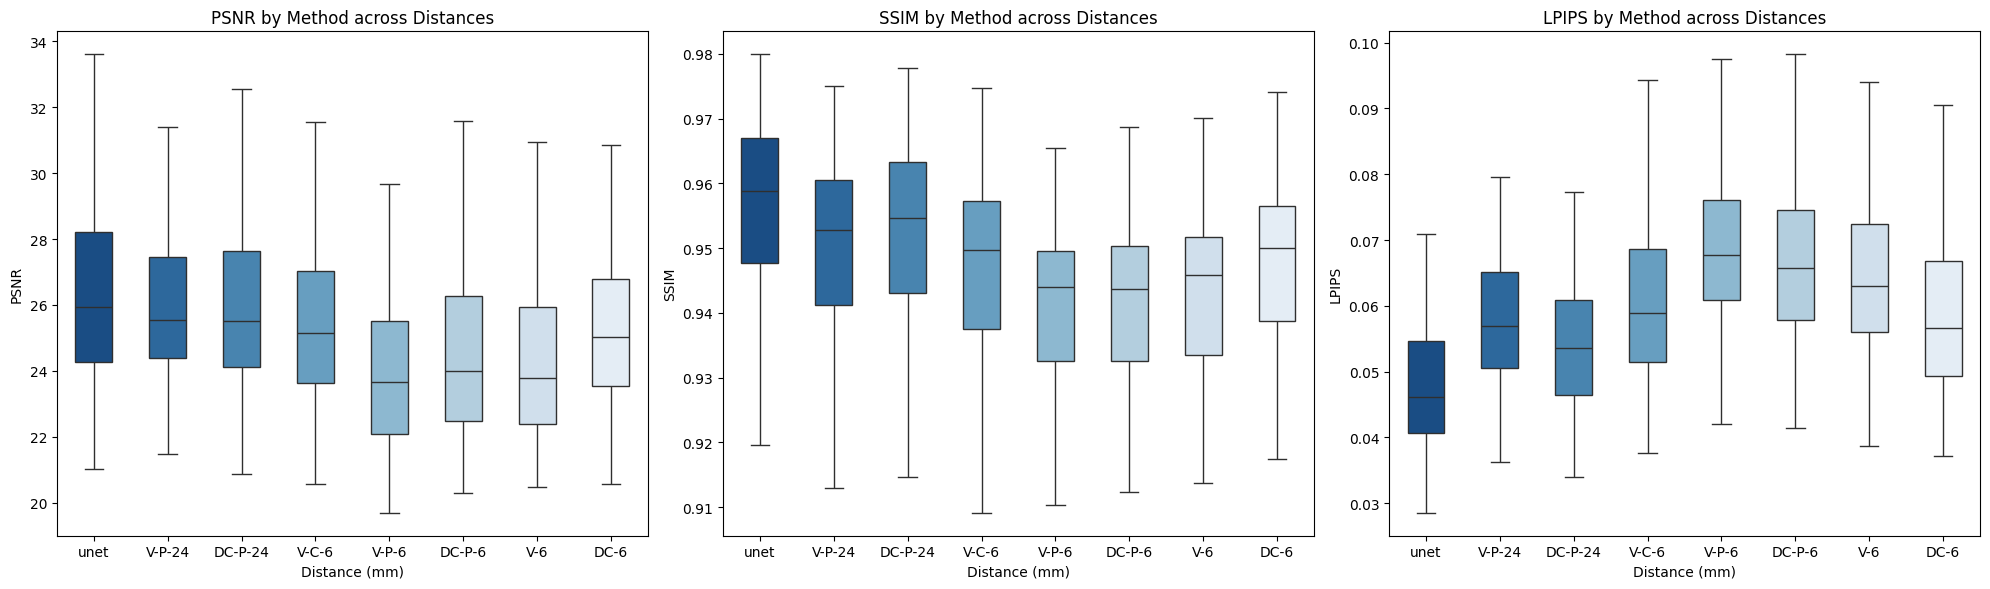

In [2]:
## VOXEL BASED METRICS ##

indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/"
files = os.listdir(Path(indir))

methods = {
    'unet',
    "_heun_vanilla_vp_10st_resampled",
    "_heun_vanilla_continuity_vp_10st_resampled",
    "_heun_vanilla_perceptual_vp_10st_resampled",
    '-L1_gradient_perceptual-vanilla-vp-24_resampled',
    '-L1_gradient_perceptual-dist_cond-vp-24_resampled',
    "_heun_dist_cond_perceptual_vp_10st_resampled",
    "_heun_dist_cond_vp_10st_resampled",
    
}
methods_labeled = {"unet": "unet", 
                '-L1_gradient_perceptual-vanilla-vp-24_resampled': 'V-P-24',
                '-L1_gradient_perceptual-dist_cond-vp-24_resampled': 'DC-P-24',
                "_heun_dist_cond_perceptual_vp_10st_resampled": "DC-P-6",
                "_heun_dist_cond_vp_10st_resampled": 'DC-6', 
                "_heun_vanilla_continuity_vp_10st_resampled": "V-C-6",
                "_heun_vanilla_perceptual_vp_10st_resampled": "V-P-6",
                "_heun_vanilla_vp_10st_resampled": "V-6",             
}

methods_ordered = ['unet', 'V-P-24', 'DC-P-24', "V-C-6", "V-P-6", "DC-P-6", "V-6",'DC-6']
records = []
psnr_table = []
ssim_table = []
lpips_table = []
labels = []

for file in files:
        file_results =  f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_10-best/voxel_metrics_10.xlsx"
        df = pd.read_excel(file_results)  # rename columns as needed
        df = df.rename(columns={df.columns[0]: "metric"}).set_index("metric")
        for c in df.columns:
            for e in methods:
                if e in c:
                    records.append({
                        'Scan': file,
                        'Method': c,
                        'PSNR': df[c]["PSNR"],
                        'SSIM': df[c]["SSIM"],
                        'LPIPS': df[c]["LPIPS"],     
                    })
        df_long = df.transpose().reset_index()

summary = pd.DataFrame.from_records(records)
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
palette = sns.color_palette("Blues", n_colors=len(methods_ordered))[::-1]
palette = dict(zip(methods_ordered, palette))
distance = ['5', '8', '10', '15', '18', '20']
# PLOTTING
metrics =  ['PSNR', 'SSIM', 'LPIPS']
pvals_table = pd.DataFrame(index=metrics, columns=distance)
fig = plt.figure(figsize=(20,6))
for i,metric in enumerate(metrics):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=summary, x='Method_Label', y=metric, showfliers=False,hue="Method_Label", palette=palette, order=methods_ordered, width=0.5)
    plt.title(f"{metric} by Method across Distances")
    plt.xlabel("Distance (mm)")
    plt.ylabel(metric)
    plt.tight_layout()
plt.show()
# fig.savefig(f'/homes/1/ma1282/marina_almeria/dbi/workdir/fig_bx_synth_10best_unet_alldbi_{metric}.svg')


    # for dist in distance:
    #     g1 = summary[(summary['Method'] == 'unet') & (summary['Dist'] == dist)][metric]
    #     g2 = summary[(summary['Method'] == '-L1_gradient_perceptual-dist_cond-vp-24_resampled') & (summary['Dist'] == dist)][metric]
    #     _, pval = mannwhitneyu(g1, g2)

    #     pvals_table.loc[dist, metric] = pval

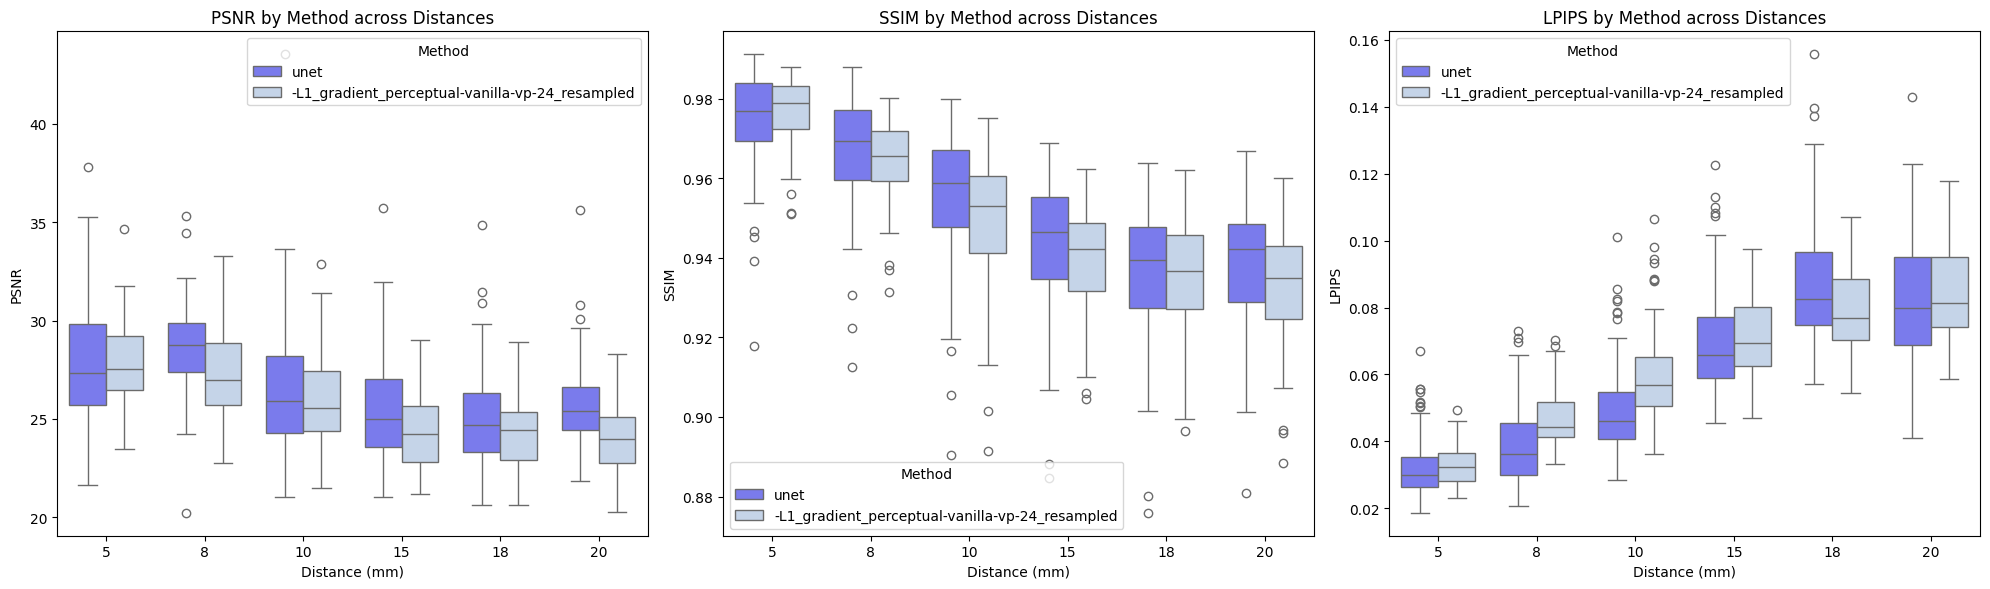

In [14]:
## VOXEL BASED METRICS ##

indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/"
files = os.listdir(Path(indir))

# methods = {
#     'unet',
#     '-L1_gradient_perceptual-dist_cond-vp-24',
# }

methods = {
    'unet',
    '-L1_gradient_perceptual-vanilla-vp-24',
}
methods_labeled = {"unet": "unet", 
                "_heun_vanilla_vp_10st_resampled": "V-vp",
                "_heun_vanilla_continuity_vp_10st_resampled": "V-C-vp-6",
                "_heun_vanilla_perceptual_i2sb_10st_resampled": "V-P-i2sb-6",
                "_heun_vanilla_perceptual_vp_10st_resampled": "V-P-vp-6",
                '-L1_gradient_perceptual-vanilla-vp-24_resampled': 'V-P-vp-24',
                '-L1_gradient_perceptual-dist_cond-vp-24_resampled': 'DC-P-vp-24',
                "_heun_dist_cond_perceptual_vp_10st_resampled": "DC-P-vp-6",
                "_heun_dist_cond_vp_10st_resampled": 'DC-vp-6',
                "_heun_dist_cond_perceptual_i2sb_10st_resampled": "DC-P-i2sb",
                
}
methods_ordered=["unet", "V-P-vp-24"]


records = []
psnr_table = []
ssim_table = []
lpips_table = []
labels = []
distances =['5', '8', '10', '15', '18', '20']
for file in files:
    for d in distances:

        file_results =  f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}/voxel_metrics_{d}.xlsx"
        if d =='10':
            file_results =  f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/dist_{d}-best/voxel_metrics_{d}.xlsx"
        df = pd.read_excel(file_results)  # rename columns as needed
        df = df.rename(columns={df.columns[0]: "metric"}).set_index("metric")
        for c in df.columns:
            for e in methods:
                if e in c:
                    records.append({
                        'Scan': file,
                        'Method': c,
                        'Dist': d,
                        'PSNR': df[c]["PSNR"],
                        'SSIM': df[c]["SSIM"],
                        'LPIPS': df[c]["LPIPS"],     
                    })
        df_long = df.transpose().reset_index()

summary = pd.DataFrame.from_records(records)
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str)) # 

palette =  ["#6768FF"] + ["#BFD3EE"] 


# PLOTTING
methods = ['unet', '-L1_gradient_perceptual-vanilla-vp-24']
metrics =  ['PSNR', 'SSIM', 'LPIPS']

scores = []
stdevs_table = pd.DataFrame(index=distances, columns=methods)
fig = plt.figure(figsize=(20,6))
for i,metric in enumerate(metrics):
    
    means_table = pd.DataFrame(index=distances, columns=methods_ordered + ['pval'])
    plt.subplot(1,3,i+1)
    sns.boxplot(data=summary, x="Dist", y=metric, hue="Method",palette=palette, width=0.75)
    plt.title(f"{metric} by Method across Distances")
    plt.xlabel("Distance (mm)")
    plt.ylabel(metric)
    plt.tight_layout()
    # plt.show()
    # fig.savefig(f'/homes/1/ma1282/marina_almeria/dbi/workdir/fig_bx_synth_unetdbi_{metric}.svg')


    for dist in ['5', '8', '10', '15', '18', '20']:
        g1 = summary[(summary['Method_Label'] == 'unet') & (summary['Dist'] == dist)][metric]
        g2 = summary[(summary['Method_Label'] == 'V-P-vp-24') & (summary['Dist'] == dist)][metric]
        means_table.loc[dist, 'unet'] = g1.mean()
        means_table.loc[dist, 'V-P-vp-24'] = g2.mean()
        if len(g1) == len(g2):
            _, pval = wilcoxon(g1, g2)
            
        else:
            _, pval = wilcoxon(g1[:g2.shape[0]], g2)
        means_table.loc[dist, 'pval'] = pval

        # stdevs_table.loc[dist, 'unet'] = g1.std()
        # stdevs_table.loc[dist, 'DC-P-vp-24'] = g2.std()

    scores.append(means_table)
    # print(stdevs_table)

In [17]:
scores[0]

,unet,V-P-vp-24,pval
5,27.882902,27.831738,0.995946
8,28.662217,27.151882,0.000419
10,26.513641,25.918429,0.020097
15,25.498968,24.425898,0.014761
18,25.038936,24.317523,0.108943
20,25.680224,24.047465,0.00001


In [12]:
missing_files = []
total_sum = 0
for file in files:
    file_folders = summary[summary['Case']==file]
    file_files = len(file_folders)
    total_sum += file_files
    if file_files != 162:
        missing_files.append(file)

In [1]:
## VOLUME BASED METRICS ## 
methods = {     "photo_recon",
                "imputed_unet",
                'dbi-L1_gradient_perceptual-dist_cond-vp-24',
}

methods_labeled_synth = {"imputed_unet": "unet", 
                   "photo_recon_10": 'photo_recon',
                "dbi_heun_vanilla_vp_10st": "V-vp-6",
                "dbi_heun_vanilla_continuity_vp_10st": "V-C-vp-6",
                "dbi_heun_vanilla_perceptual_i2sb_10st": "V-P-i2sb-6",
                "dbi_heun_vanilla_perceptual_vp_10st": "V-P-vp-6",
                'dbi-L1_gradient_perceptual-vanilla-vp-24': 'V-P-vp-24',
                'dbi-L1_gradient_perceptual-dist_cond-vp-24': 'DC-P-vp-24',
                "dbi_heun_dist_cond_perceptual_vp_10st": "DC-P-vp-6",
                "dbi_heun_dist_cond_vp_10st": 'DC-vp-6',
                "dbi_heun_dist_cond_perceptual_i2sb_10st": "DC-P-i2sb-6",
                
}

methods_cp = {"photo_recon_10_vs_imputed_unet": "Photo-UNet", 
              "photo_recon_10_vs_dbi-L1_gradient_perceptual-dist_cond-vp-24": "Photo-DBI",
              "imputed_unet_vs_dbi-L1_gradient_perceptual-dist_cond-vp-24": "DBI-UNet"}



records = []
indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic"
files = os.listdir(Path(indir))


label_names = { # for synthetic segmentation 
    2:"WM", 3:"Cortex", 4:"Ventricle", 
    10:"Thalamus",
    11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
    18:"Amygdala",
}

files = {"interp_synthvol_00","interp_synthvol_03","interp_synthvol_05","interp_synthvol_07","interp_synthvol_010",
         "interp_synthvol_011","interp_synthvol_012","interp_synthvol_015","interp_synthvol_016","interp_synthvol_017",
         "interp_synthvol_019","interp_synthvol_021","interp_synthvol_023","interp_synthvol_030","interp_synthvol_031",
         "interp_synthvol_032","interp_synthvol_034","interp_synthvol_036","interp_synthvol_038","interp_synthvol_039",
         "interp_synthvol_040","interp_synthvol_041","interp_synthvol_042","interp_synthvol_043","interp_synthvol_044",
         "interp_synthvol_045","interp_synthvol_046","interp_synthvol_047","interp_synthvol_048","interp_synthvol_055",
         "interp_synthvol_057","interp_synthvol_058","interp_synthvol_061","interp_synthvol_064","interp_synthvol_065",
         "interp_synthvol_075","interp_synthvol_078","interp_synthvol_079","interp_synthvol_080","interp_synthvol_084",
         "interp_synthvol_085","interp_synthvol_088","interp_synthvol_089","interp_synthvol_090","interp_synthvol_094",
         "interp_synthvol_096","interp_synthvol_098","interp_synthvol_099"}
distances = ['5', '8', '10', '15', '18', '20']
for file in files:
    for method in methods:
        for d in distances:
            file_results = f"{indir}/{file}/dist_{d}/synthseg_{method}.json"
            
            if d == '10':
                file_results = f"{indir}/{file}/dist_10-best/synthseg_{method}.json"

            if os.path.exists(file_results):
                df = pd.read_csv(file_results, sep="\t", header=None)
                df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                df = df[df["Label"] != 0]
            
                for i in label_names:
                    if i in df["Label"].values:
                        row = df[df["Label"] == i].copy()
                        
                        records.append({               
                            "Case": file,              # subject/case id
                            "Method": method,          # "unet" or "photo_recon"
                            "Distance": d,
                            "Label": int(row["Label"]),  # region id
                            "Dice": float(row["Dice"]),
                            "VE": float(row["VE"]),
                        })

blue_palette = sns.color_palette("Blues", n_colors=10) # lighter to darker blues
# palette = sns.color_palette("coolwarm", n_colors=10)
palette = ["#FFFBFF"] + ["#6768FF"] + blue_palette
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled_synth).fillna(summary["Method"].astype(str))

NameError: name 'os' is not defined

/home/scratch/ipykernel_3446146/278012969.py:16: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.boxplot(data=data_sub, y=metric, x="Region",
/home/scratch/ipykernel_3446146/278012969.py:16: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.boxplot(data=data_sub, y=metric, x="Region",
/home/scratch/ipykernel_3446146/278012969.py:16: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.boxplot(data=data_sub, y=metric, x="Region",
/home/scratch/ipykernel_3446146/278012969.py:16: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.boxplot(data=data_sub, y=metric, x="Region",
/home/scratch/ipykernel_3446146/278012969.py:16: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.boxplot(data=data_sub, y=metric, x="Region",
/home/scratch/ipykernel_3

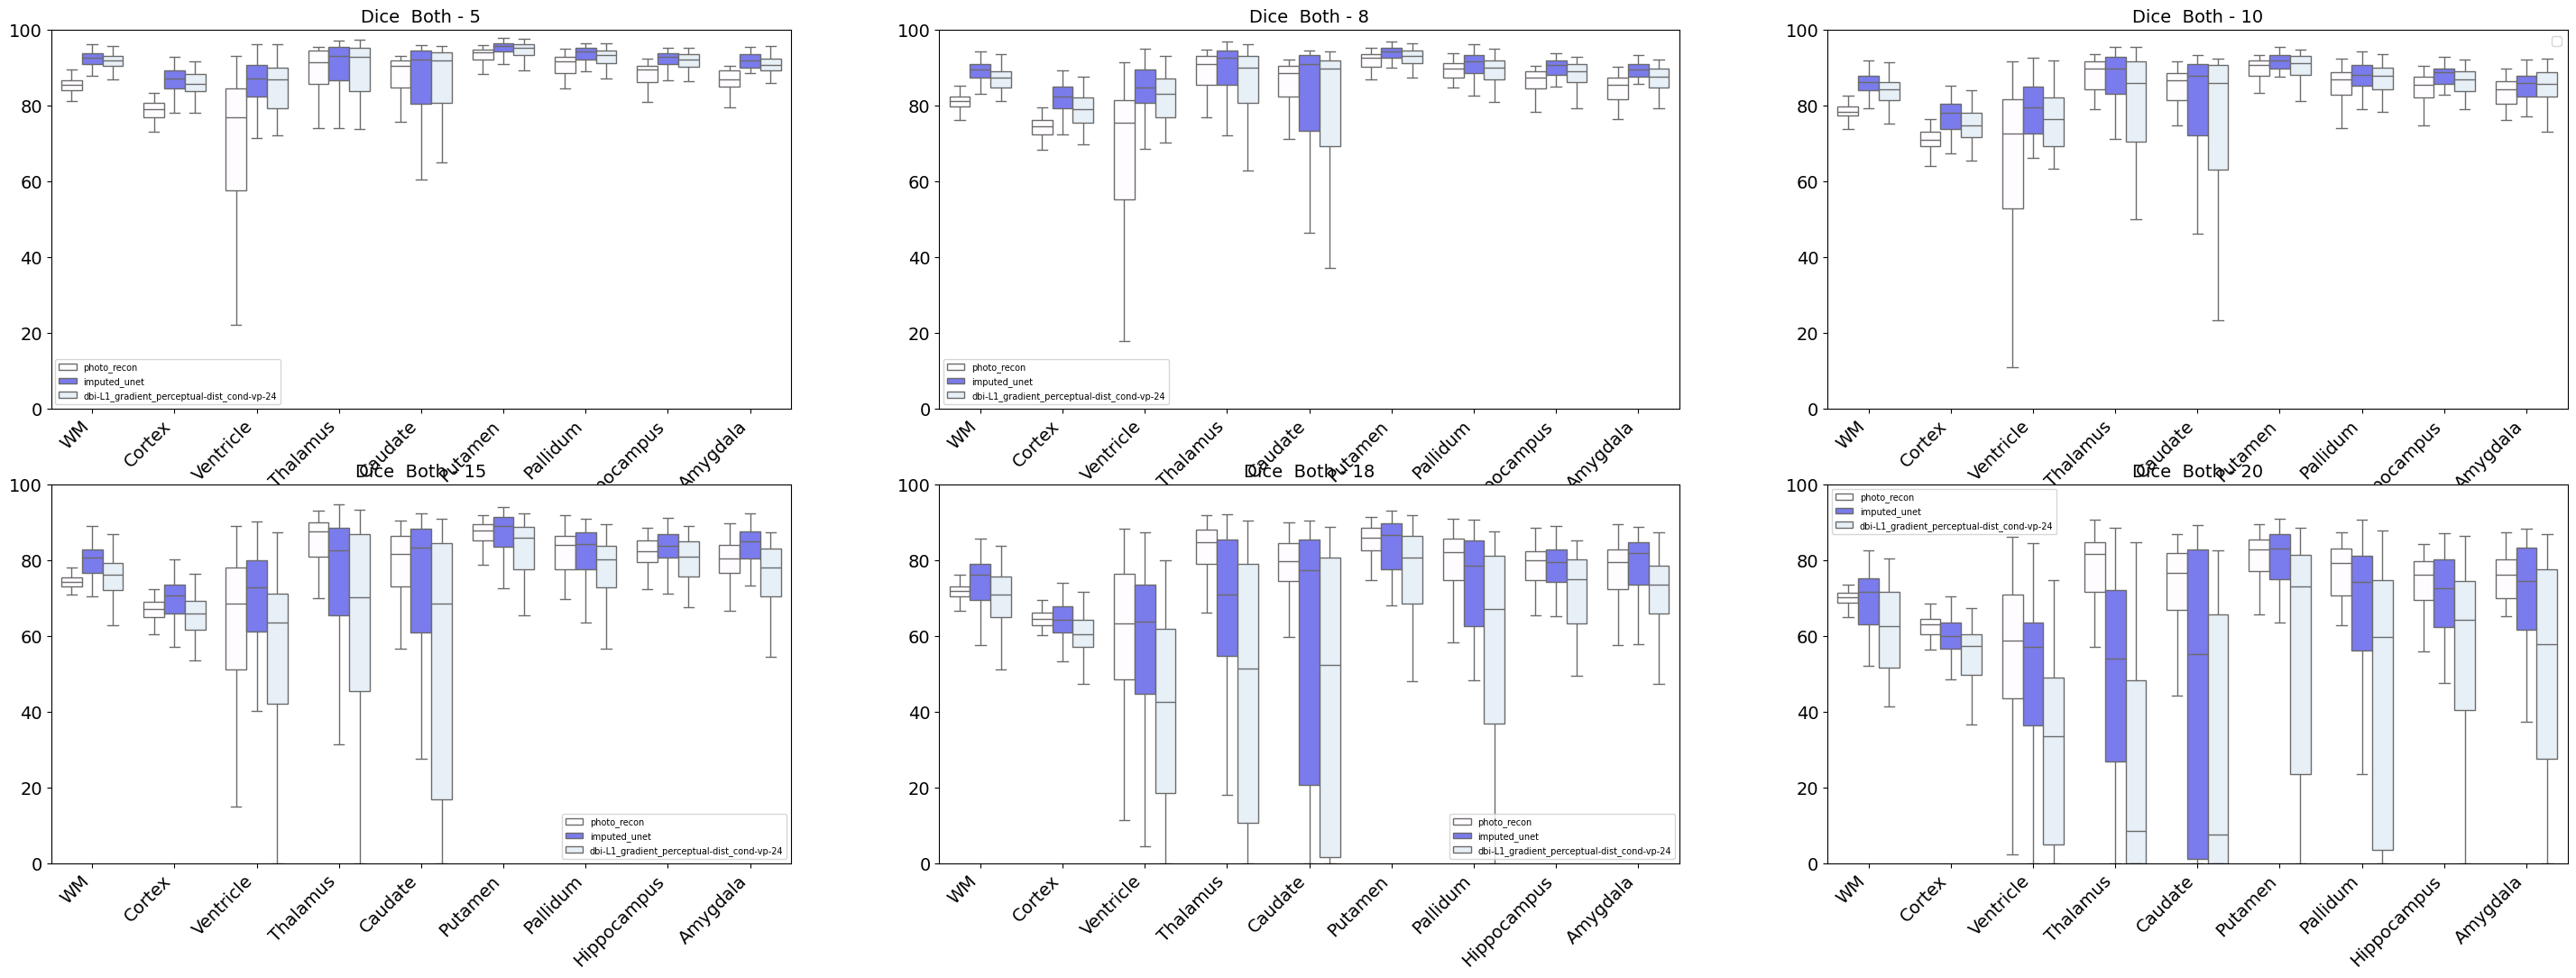

AttributeError: module 'numpy' has no attribute 'AxisError'

<Figure size 640x480 with 0 Axes>

In [ ]:
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled_synth).fillna(summary["Method"].astype(str))
methods_compare = ['photo-unet', 'photo-dbi', 'dbi-unet']
methods_ordered = ['photo_recon', 'imputed_unet', 'dbi-L1_gradient_perceptual-vanilla-vp-24']
metric='Dice'

fig, axes = plt.subplots(2, 3, figsize=(12*3, 12), sharey=True)
axes = axes.flatten()
j = 0
distances = ['5', '8', '10', '15','18', '20']
for sub in distances:
    data_sub = summary[summary["Distance"] == sub].copy()

    ax = axes[j]

    sns.boxplot(data=data_sub, y=metric, x="Region",
                hue="Method", hue_order=methods_ordered, palette=palette, dodge=True, showfliers=False, width=0.75, ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")

    if j != 2:
        ax.legend(title="", loc="best", fontsize=7)
    else:
        ax.legend('')

    ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
    j += 1

    if metric =="Dice":
        plt.ylim(0,100)
    elif metric =="VE":
        plt.ylim(0,150)

        
plt.show()
plt.tight_layout()


mean_dice_table = []
for dist in distances:
    pvalues_dice_table = pd.DataFrame(index=label_names.values(), columns=["Original", "UNet", "Diffusion"] +methods_compare)
    for label in label_names:
        g2 = summary[(summary['Method'] == 'imputed_unet') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        g1 = summary[(summary['Method'] == 'photo_recon') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        g3 = summary[(summary['Method'] == 'dbi-L1_gradient_perceptual-dist_cond-vp-24') & (summary['Distance'] == dist) & (summary['Label'] == label)]['Dice']
        
        _, pval12 = wilcoxon(g1, g2)
        _, pval23 = wilcoxon(g3, g2)
        _, pval13 = wilcoxon(g3, g1)

        pvalues_dice_table.loc[label_names[label], 'photo-unet'] = pval12
        pvalues_dice_table.loc[label_names[label], 'photo-dbi'] = pval13
        pvalues_dice_table.loc[label_names[label], 'dbi-unet'] = pval23
    print(pvalues_dice_table)
# fig.savefig(f'/homes/1/ma1282/marina_almeria/dbi/workdir/fig_dice_synth_unet_dbi_6dists.svg')

In [62]:
g3.shape

(48,)

In [61]:
g2.shape

(47,)

/home/scratch/ipykernel_3164669/3615228575.py:75: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/3615228575.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_3164669/3615228575.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_3164669/3615228575.py:75: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/3615228575.py:76: FutureWarning: Calling float on a single ele

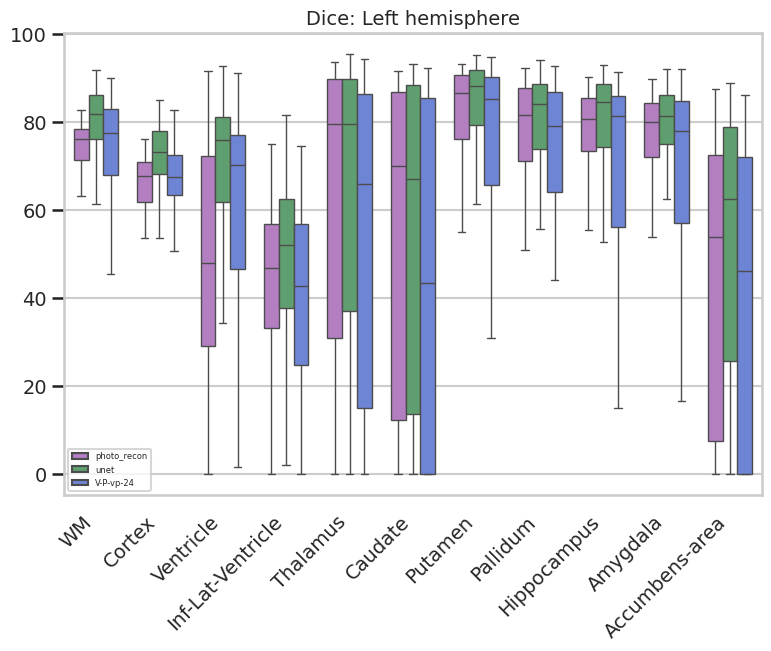

/home/scratch/ipykernel_3164669/3615228575.py:96: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=summary, y=metric, hue_order=method_order, x="Region",


<Figure size 640x480 with 0 Axes>

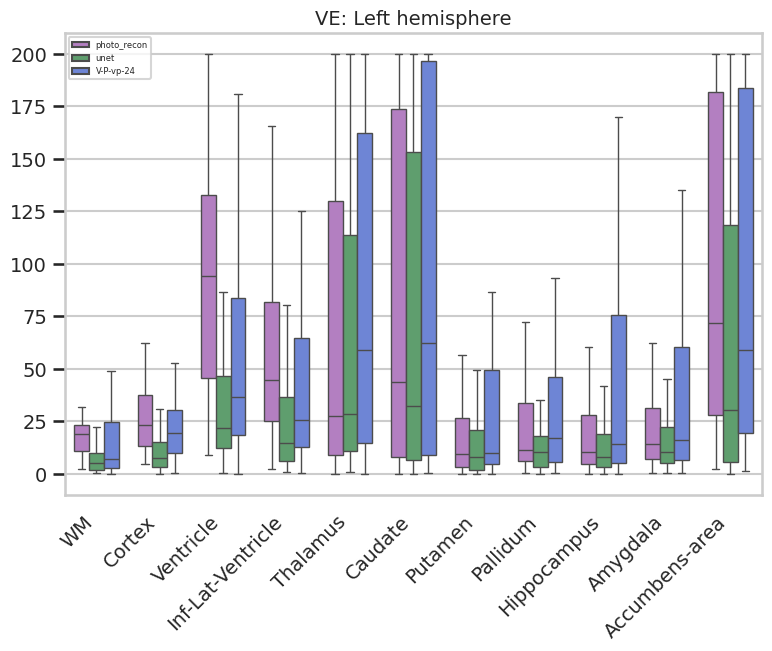

<Figure size 640x480 with 0 Axes>

In [160]:
# 
# SYNTHETIC PREDICTION
# 

methods = {"_imputed_unet", 
                   "_photo_recon_10",
                "_dbi_heun_vanilla_vp_10st",
                "_dbi_heun_vanilla_continuity_vp_10st",
                "_dbi_heun_vanilla_perceptual_i2sb_10st",
                "_dbi_heun_vanilla_perceptual_vp_10st",
                '_dbi-L1_gradient_perceptual-vanilla-vp-24',
                "_dbi_heun_dist_cond_perceptual_vp_10st",
                "_dbi_heun_dist_cond_vp_10st",
                "_dbi_heun_dist_cond_perceptual_i2sb_10st",
}

methods_reduced = {"_imputed_unet", 
                   "_photo_recon_10",
                '_dbi-L1_gradient_perceptual-vanilla-vp-24',
                
}
methods_labeled = {"_imputed_unet": "unet", 
                   "_photo_recon_10": 'photo_recon',
                "_dbi_heun_vanilla_vp_10st": "V-vp",
                "_dbi_heun_vanilla_continuity_vp_10st": "V-C-vp-6",
                "_dbi_heun_vanilla_perceptual_i2sb_10st": "V-P-i2sb-6",
                "_dbi_heun_vanilla_perceptual_vp_10st": "V-P-vp-6",
                '_dbi-L1_gradient_perceptual-vanilla-vp-24': 'V-P-vp-24',
                "_dbi_heun_dist_cond_perceptual_vp_10st": "DC-P-vp-6",
                "_dbi_heun_dist_cond_vp_10st": 'DC-vp-6',
                "_dbi_heun_dist_cond_perceptual_i2sb_10st": "DC-P-i2sb",
                
}



# methods_cp = {"photo_recon_vs_imputed_unet": "Photo-UNet", 
#               "photo_recon_vs_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24": "Photo-DBI",
#               "imputed_unet_vs_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24": "DBI-UNet"}



records = []
indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic"
files = os.listdir(Path(indir))


label_names = { # for synthetic segmentation 
    2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 
    10:"Thalamus",
    11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
    18:"Amygdala", 26:"Accumbens-area"
}

extreme_cases = {'interp_synthvol_017','interp_synthvol_018', 'interp_synthvol_022', 'interp_synthvol_024', 'interp_synthvol_029', 'interp_synthvol_033', 'interp_synthvol_043',
                 'interp_synthvol_050', 'interp_synthvol_054', 'interp_synthvol_063', 'interp_synthvol_070', 'interp_synthvol_072', 'interp_synthvol_074', 'interp_synthvol_076', 
                'interp_synthvol_081', 'interp_synthvol_083', 'interp_synthvol_097'}
missed=[]
for file in files:
    # if file not in extreme_cases:
        for method in methods_reduced:
            file_results = f"{indir}/{file}/dist_10-best/synthseg{method}.json"
            if os.path.exists(file_results):
                df = pd.read_csv(file_results, sep="\t", header=None)
                df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                df = df[df["Label"] != 0]
                
                for i in label_names:
                    if i in df["Label"].values:
                        row = df[df["Label"] == i].copy()
                        
                        records.append({               
                            "Case": file,              # subject/case id
                            "Method": method,          # "unet" or "photo_recon"
                            "Label": int(row["Label"]),  # region id
                            "Dice": float(row["Dice"]),
                            "VE": float(row["VE"]),
                        })
    # else:
    #     missed.append(file)

# blue_palette = sns.color_palette("Blues", n_colors=10) # lighter to darker blues
palette = sns.color_palette("coolwarm", n_colors=8)
palette = ['#B974CC'] + ['#55A868'] + palette

summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))

method_order = ['photo_recon', 'unet', 'V-P-vp-24']


for metric in ["Dice", "VE"]:
    fig,ax = plt.subplots(1,1, figsize=(9*1, 6), sharey=True)

    sns.boxplot(data=summary, y=metric, hue_order=method_order, x="Region", 
                hue="Method_Label", palette=palette, dodge=True, showfliers=False, width=0.7, ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend(title="", loc="best", fontsize=6)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    ax.set_title(f"{metric}: Left hemisphere", fontsize=14)
    j += 1

    # if metric =="Dice":
    #     plt.ylim(0,95)
    # elif metric =="VE":
    #     plt.ylim(0,150)
    plt.show()
    plt.tight_layout()
    # fig.savefig(f"./workdir/segmentations_synthseg_synthetic_dbi_methods_{metric}.svg")

## COMPUTING THE PVALUES
# for metric in ["Dice", "VE"]:
#     DD = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
#     EE = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
#     # WW = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
#     out_path = f"./workdir/segmentations_neurosynth_real_unet_photo_dbi_{metric}.xlsx"
#     with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
#         for sub in subfiles:
#             data_sub = summary[summary["Sub"] == sub].copy()
#             for table_col in methods_cp:

#                 # COMPUTE THE P.VALUES 
#                 for i in label_names.values():
#                     if i in data_sub["Region"].values:
#                         row_i = methods_cp[table_col]
#                         m1, m2 = table_col.split("_vs_")
                        
#                         data_sub_label = data_sub[data_sub["Region"] == i].copy()
#                         g1 = data_sub_label[data_sub_label["Method"] == m1][metric].values
#                         g2 = data_sub_label[data_sub_label["Method"] == m2][metric].values
#                         # _,pval_wx = wilcoxon(g1,g2)
#                         _,pval_mann = mannwhitneyu(g1,g2)
#                         diff = (g2 - g1) # column to row comparison ****
#                         eff_size = diff.mean() / diff.std()

#                         DD[row_i][i] = pval_mann
#                         EE[row_i][i] = eff_size
#                         # WW[row_i][i] = pval_mann
                        

#                 DD.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
#                 # WW.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
#                 EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}_{sub}")


In [ ]:
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/synthseg_dice.txt"
methods = {"dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond", }

# methods_ex = {"dbi-L1_gradient_perceptual-dist_cond-vp_12mm", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond_12mm", "dbi-L1_gradient_continuity-vanilla_12mm", "dbi-L1_gradient_perceptual-vanilla-vp-24_12mm"}
files = os.listdir(Path(indir))
with open(output_txt, "w") as f:
    for file in files:
        for m in methods:
            # cmd = (
            #     f"/autofs/vast/lemon/software/NeuroSynth/run_NeuroSynth.sh "
            #     f"--i {indir}/{file}/imputed_{method}_12mm.nii.gz "
            #     f"--o {indir}/{file}/neurosynth/neurosynth_imputed_{method}_12mm "
            #     f"--mode exvivo "
            #     f"--device cuda "
            # )  

            cmd = (
                f"mri_synthseg "
                f"{indir}/{file}/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/interp_synthvol_07/dist_10-best/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24.mgz "
                f"{indir}/{file}/neurosynth/neurosynth_imputed_{method}_12mm "
                f"--mode exvivo "
                f"--device cuda "
            )  
            f.write(cmd + "\n")
            cmd = (
                f"mri_convert "
                f"{indir}/{file}/neurosynth/neurosynth_imputed_{method}_12mm/segmentation.mgz "
                f"{indir}/{file}/neurosynth/neurosynth_imputed_{method}_12mm/segmentation.mgz "
                f"-rl {indir}/{file}/neurosynth/neurosynth_mri/segmentation.mgz "
                f"-odt float "
            )  
            f.write(cmd + "\n")
            cmd = (
                f"mri_compute_overlap "
                f"-a "
                f"-l {indir}/{file}/synthseg_{method}_12mm.json "
                f"{indir}/{file}/synthseg_{method}_12mm_res.mgz "
                f"{indir}/{file}/synthseg_mri.mgz "
            )  
            f.write(cmd + "\n")   




In [ ]:
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
# files = os.listdir(Path(indir))
# files =['19-0019', '18-0086', '18-1196', '18-1680']
# files =['18-2128', '18-1045', '18-1724', '19-0037', '18-2260'] 
# files = ['18-1690', '18-1343', '18-1470', '18-1930', '18-1705', '18-0444', '17-0333', '18-1754', '19-0138', '19-0148']
# files = ['18-1704', '18-1913', '18-2259', '18-2056', '18-1327', '19-0100', '18-0817', '18-1132', '18-1274']
# '18-1690' '18-1343' '18-1470' '18-1930' '18-1705' '18-0444' '17-0333' '18-1754' '19-0138'
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/synthseg_dice.txt"
methods = {"dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond", }
missing = {}
# distances=["4mm", "8mm"]
dist="12mm"
with open(output_txt, "w") as f:
    for scan in os.listdir(indir):
        missing[scan] = []
        for method in methods:
            nfile = f"{indir}/{scan}/neurosynth/neurosynth_imputed_{method}_12mm/segmentation.json"
            # if os.path.exists(nfile) ==False:
            #     missing[scan].append(nfile)
            # for dist in distances:
                # cmd = (
                #     f"mri_synthseg "
                #     f"--i {indir}/{file}/imputed_{method}_{dist}.nii.gz "
                #     f"--o {indir}/{file}/synthseg_{method}_{dist}.mgz "
                #     f"--threads 20 "
                # )
                # f.write(cmd + "\n")
                # cmd = (
                #     f"mri_convert "
                #     f"{indir}/{file}/synthseg_{method}_{dist}.mgz "
                #     f"{indir}/{file}/synthseg_{method}_{dist}_res.mgz "
                #     f"-rl {indir}/{file}/synthseg_mri.mgz "
                #     f"-rt nearest "
                #     f"-odt float "
                #     f"--threads 20 "
                # )
                # f.write(cmd + "\n")
                # cmd = (
                #     f"mri_compute_overlap "
                #     f"-a "
                #     f"-l {indir}/{file}/synthseg_{method}_{dist}.json "
                #     f"{indir}/{file}/synthseg_{method}_{dist}_res.mgz "
                #     f"{indir}/{file}/synthseg_mri.mgz "
                # )
                # f.write(cmd + "\n")

In [ ]:
# DBI METHODS -> PLOTTING ALL THE LABELS -> FOR NEUROSYNTH!!!!
# methods = ["dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond"]
methods = ["photo_recon", "imputed_unet","imputed_dbi-L1_gradient_perceptual-vanilla-vp-24"]
methods_labeled = {
            "photo_recon": "Photo Recon",
            "imputed_unet": "Imputation UNet",
           "imputed_dbi-L1_gradient_perceptual-vanilla-vp-24": "Imputation DBI", 
           }

methods_cp = {"photo_recon_vs_imputed_unet": "Photo-UNet", 
              "photo_recon_vs_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24": "Photo-DBI",
              "imputed_unet_vs_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24": "DBI-UNet"}




# methods_labeled = {"dbi-L1_gradient-vanilla": "V-vp-6", 
#                    "dbi-L1_gradient_perceptual-vanilla": "V-P-vp-6", 
#                    "dbi-L1_gradient_perceptual-vanilla-i2sb_cond": "V-P-i2sb-6", 
#                    "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18": "V-P-i2sb-18",
#                    "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24": "V-P-i2sb-24",
#                    "dbi-L1_gradient_perceptual-vanilla-vp-24": "V-P-vp-24", 
#                    "dbi-L1_gradient_continuity-vanilla": "V-C-vp-6", 
#                    "dbi-L1_gradient-dist_cond": "DC-vp-6", 
#                    "dbi-L1_gradient_perceptual-dist_cond-vp": "DC-P-vp", 
#                    "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond": "DC-P-i2sb-6"}


records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))
subfiles=["4mm", "8mm", "12mm"]
# label_names = {2:"L-WM", 3:"L-Cortex", 4:"L-Ventricle", 5:"L-Inf-Lat-Ventricle", 10:"L-Thalamus",
#         11:"L-Caudate", 12:"L-Putamen", 13:"L-Pallidum", 17:"L-Hippocampus",
#         18:"L-Amygdala", 26:"L-Accumbens-area", 77:"L-WM hypo", 819:"L-HypoThal-noMB", 821:"L-Fornix",
#         843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
#         41:"R-WM", 42:"R-Cortex", 43:"R-Ventricle", 44:"R-Inf-Lat-Ventricle", 49:"R-Thalamus",
#         50:"R-Caudate", 51:"R-Putamen", 52:"R-Pallidum", 53:"R-Hippocampus",
#         54:"R-Amygdala", 58:"R-Accumbens-area", 77:"R-WM hypo", 820:"R-HypoThal-noMB", 822:"R-Fornix",
#         844:"R-MammillaryBody", 866:"R-BasalForebrain", 870:"R-SeptalNuc"
# }

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc"
}
for sub in subfiles:
        for file in files:
            for method in methods:
                file_results = f"{indir}/{file}/neurosynth/neurosynth_{method}_{sub}/segmentation.json"
                if os.path.exists(file_results):
                    df = pd.read_csv(file_results, sep="\t", header=None)
                    df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                    df = df[df["Label"] != 0]
                    
                    for i in label_names:
                        if i in df["Label"].values:
                            row = df[df["Label"] == i].copy()
                            
                            records.append({
                                "Sub": sub,                # e.g., 4, 8, 12 (mm)
                                "Case": file,              # subject/case id
                                "Method": method,          # "unet" or "photo_recon"
                                "Label": int(row["Label"]),  # region id
                                "Dice": float(row["Dice"]),
                                "VE": float(row["VE"]),
                            })

# blue_palette = sns.color_palette("Blues", n_colors=10) # lighter to darker blues
palette = sns.color_palette("coolwarm", n_colors=1)
palette = ['#B974CC'] + ['#55A868'] + palette

summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
for metric in ["Dice", "VE"]:
    fig, axes = plt.subplots(1, len(subfiles), figsize=(9*len(subfiles), 6), sharey=True)
    j = 0
    for sub in subfiles:
        data_sub = summary[summary["Sub"] == sub].copy()
        # method_order = sorted(
        #     data_sub["Method_Label"].unique(),
        #     key=lambda x: (int(x) if str(x).isdigit() else 10**9, str(x))
        # )

        ax = axes[j]
        # sns.boxplot(data=data_sub, y=metric, x="Region",
        #             hue="Method_Label", palette=palette, dodge=True, showfliers=False, width=0.7, ax=ax, hue_order=method_order)
        sns.boxplot(data=data_sub, y=metric, x="Region",
                    hue="Method_Label", palette=palette, dodge=True, showfliers=False, width=0.7, ax=ax)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.legend(title="", loc="best", fontsize=14)
        ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
        ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
        j += 1

    if metric =="Dice":
        plt.ylim(0,95)
    elif metric =="VE":
        plt.ylim(0,150)
    plt.show()
    plt.tight_layout()
    fig.savefig(f"./workdir/segmentations_neurosynth_dbi_methods_{metric}.svg")

## COMPUTING THE PVALUES
# for metric in ["Dice", "VE"]:
    # DD = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
    # EE = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
    # # WW = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
    # out_path = f"./workdir/segmentations_neurosynth_real_unet_photo_dbi_{metric}.xlsx"
    # with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    #     for sub in subfiles:
    #         data_sub = summary[summary["Sub"] == sub].copy()
    #         for table_col in methods_cp:

    #             # COMPUTE THE P.VALUES 
    #             for i in label_names.values():
    #                 if i in data_sub["Region"].values:
    #                     row_i = methods_cp[table_col]
    #                     m1, m2 = table_col.split("_vs_")
                        
    #                     data_sub_label = data_sub[data_sub["Region"] == i].copy()
    #                     g1 = data_sub_label[data_sub_label["Method"] == m1][metric].values
    #                     g2 = data_sub_label[data_sub_label["Method"] == m2][metric].values
    #                     # _,pval_wx = wilcoxon(g1,g2)
    #                     _,pval_mann = mannwhitneyu(g1,g2)
    #                     diff = (g2 - g1) # column to row comparison ****
    #                     eff_size = diff.mean() / diff.std()

    #                     DD[row_i][i] = pval_mann
    #                     EE[row_i][i] = eff_size
    #                     # WW[row_i][i] = pval_mann
                        

    #             DD.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
    #             # WW.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
    #             EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}_{sub}")


In [ ]:
for i in label_names.values():
    if i in data_sub["Region"].values:
        row_i = methods_cp[table_col]
        m1, m2 = table_col.split("_vs_")
        
        data_sub_label = data_sub[data_sub["Region"] == i].copy()
        g1 = data_sub_label[data_sub_label["Method"] == m1][metric].values
        g2 = data_sub_label[data_sub_label["Method"] == m2][metric].values
        # _,pval_wx = wilcoxon(g1,g2)
        _,pval_mann = mannwhitneyu(g1,g2)
        diff = (g2 - g1) # column to row comparison ****
        eff_size = diff.mean() / diff.std()

        DD[row_i][i] = pval_mann
        EE[row_i][i] = eff_size
        # WW[row_i][i] = pval_mann
        

DD.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
# WW.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}_{sub}")

/home/scratch/ipykernel_3164669/2197156841.py:69: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/2197156841.py:70: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_3164669/2197156841.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_3164669/2197156841.py:69: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/2197156841.py:70: FutureWarning: Calling float on a single ele

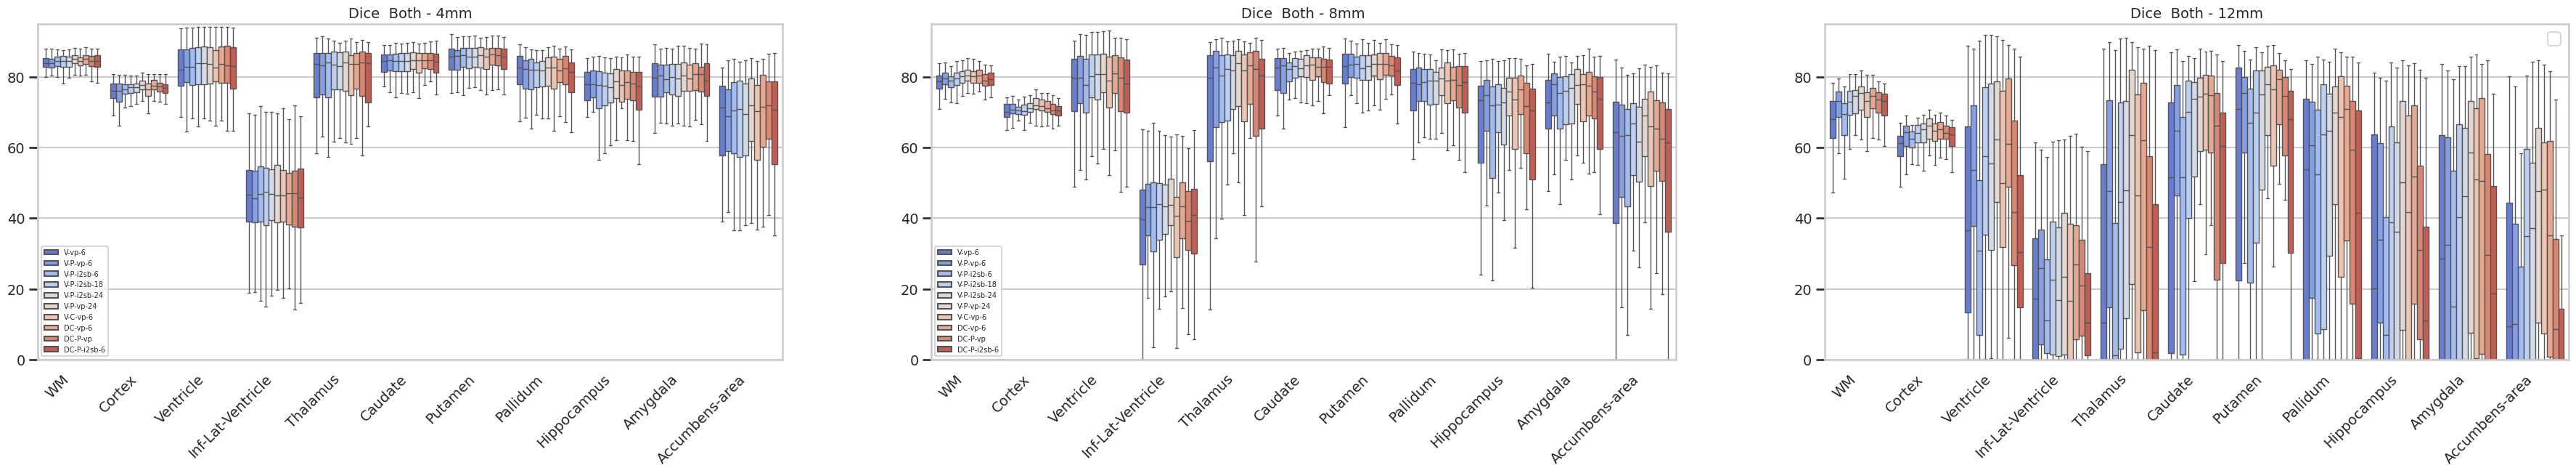

<Figure size 640x480 with 0 Axes>

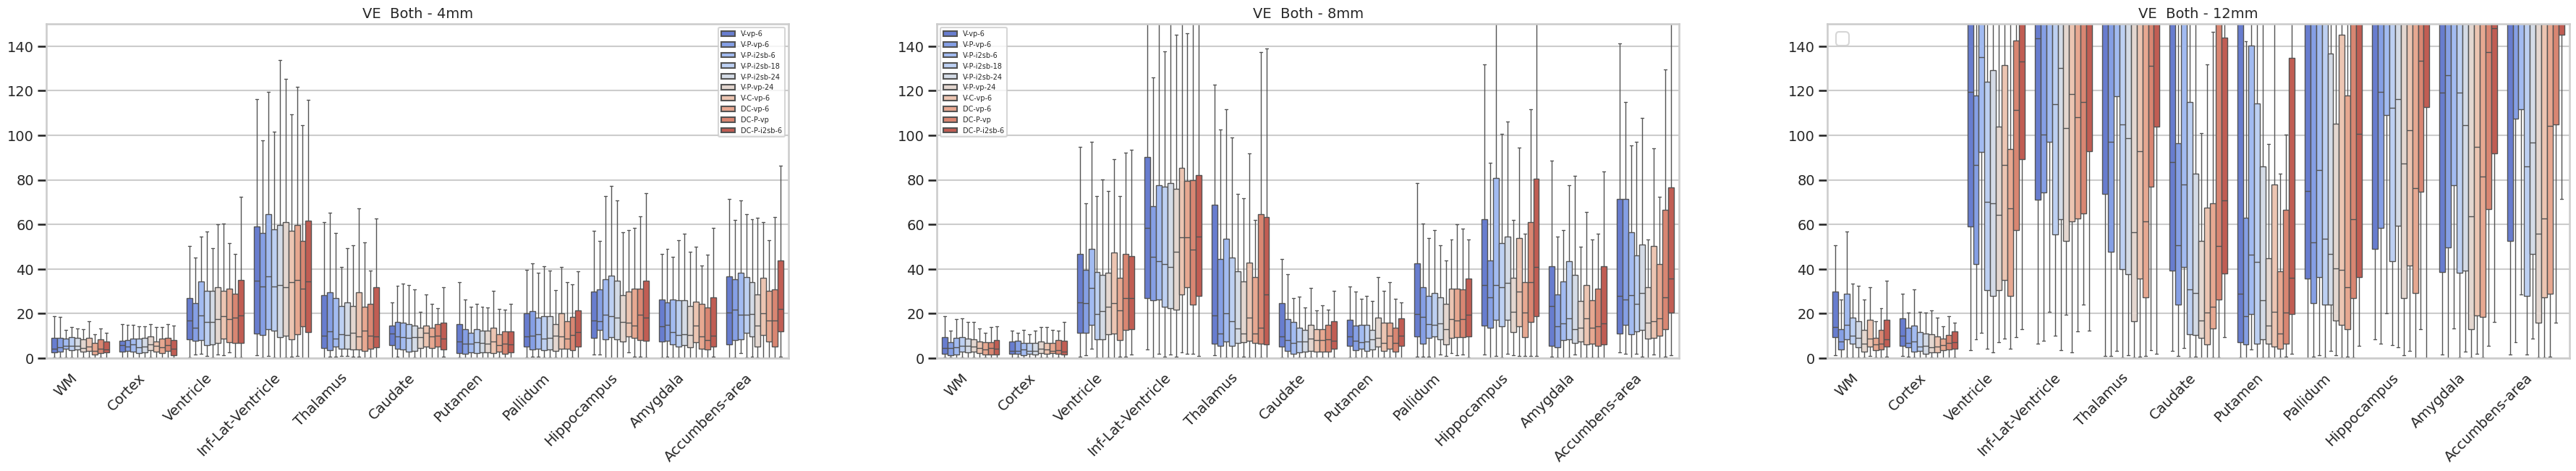

<Figure size 640x480 with 0 Axes>

In [ ]:
# DBI METHODS -> PLOTTING ALL THE LABELS
methods = ["dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond"]
# methods = ["photo_recon", "imputed_unet","dbi-L1_gradient_perceptual-vanilla-vp-24_lr"]
# methods_labeled = {
#             "photo_recon": "Photo Recon",
#             "imputed_unet": "Imputation UNet",
#            "dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "Imputation DBI", 
#            }

# methods_cp = {"photo_recon_vs_imputed_unet": "Photo-UNet", 
#               "photo_recon_vs_dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "Photo-DBI",
#               "imputed_unet_vs_dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "DBI-UNet"}




methods_labeled = {"dbi-L1_gradient-vanilla": "V-vp-6", 
                   "dbi-L1_gradient_perceptual-vanilla": "V-P-vp-6", 
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond": "V-P-i2sb-6", 
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18": "V-P-i2sb-18",
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24": "V-P-i2sb-24",
                   "dbi-L1_gradient_perceptual-vanilla-vp-24": "V-P-vp-24", 
                   "dbi-L1_gradient_continuity-vanilla": "V-C-vp-6", 
                   "dbi-L1_gradient-dist_cond": "DC-vp-6", 
                   "dbi-L1_gradient_perceptual-dist_cond-vp": "DC-P-vp", 
                   "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond": "DC-P-i2sb-6"}


records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))
subfiles=["4mm", "8mm", "12mm"]
# label_names = {2:"L-WM", 3:"L-Cortex", 4:"L-Ventricle", 5:"L-Inf-Lat-Ventricle", 10:"L-Thalamus",
#         11:"L-Caudate", 12:"L-Putamen", 13:"L-Pallidum", 17:"L-Hippocampus",
#         18:"L-Amygdala", 26:"L-Accumbens-area", 77:"L-WM hypo", 819:"L-HypoThal-noMB", 821:"L-Fornix",
#         843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
#         41:"R-WM", 42:"R-Cortex", 43:"R-Ventricle", 44:"R-Inf-Lat-Ventricle", 49:"R-Thalamus",
#         50:"R-Caudate", 51:"R-Putamen", 52:"R-Pallidum", 53:"R-Hippocampus",
#         54:"R-Amygdala", 58:"R-Accumbens-area", 77:"R-WM hypo", 820:"R-HypoThal-noMB", 822:"R-Fornix",
#         844:"R-MammillaryBody", 866:"R-BasalForebrain", 870:"R-SeptalNuc"
# }

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc"
}
for sub in subfiles:
        for file in files:
            for method in methods:
                file_results = f"{indir}/{file}/synthseg_{method}_{sub}.json"
                if os.path.exists(file_results):
                    df = pd.read_csv(file_results, sep="\t", header=None)
                    df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                    df = df[df["Label"] != 0]
                    
                    for i in label_names:
                        if i in df["Label"].values:
                            row = df[df["Label"] == i].copy()
                            
                            records.append({
                                "Sub": sub,                # e.g., 4, 8, 12 (mm)
                                "Case": file,              # subject/case id
                                "Method": method,          # "unet" or "photo_recon"
                                "Label": int(row["Label"]),  # region id
                                "Dice": float(row["Dice"]),
                                "VE": float(row["VE"]),
                            })

# blue_palette = sns.color_palette("Blues", n_colors=10) # lighter to darker blues
palette = sns.color_palette("coolwarm", n_colors=10)
# palette = ['#B974CC'] + ['#55A868'] + palette

summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
for metric in ["Dice", "VE"]:
    fig, axes = plt.subplots(1, len(subfiles), figsize=(15*len(subfiles), 6), sharey=True)
    j = 0
    for sub in subfiles:
        data_sub = summary[summary["Sub"] == sub].copy()
        # method_order = sorted(
        #     data_sub["Method_Label"].unique(),
        #     key=lambda x: (int(x) if str(x).isdigit() else 10**9, str(x))
        # )

        ax = axes[j]
        # sns.boxplot(data=data_sub, y=metric, x="Region",
        #             hue="Method_Label", palette=palette, dodge=True, showfliers=False, width=0.7, ax=ax, hue_order=method_order)
        sns.boxplot(data=data_sub, y=metric, x="Region",
                    hue="Method_Label", palette=palette, dodge=True, showfliers=False, width=0.85, ax=ax)
        ax.set_ylabel("")
        ax.set_xlabel("")
        if j != 2:
            ax.legend(title="", loc="best", fontsize=7)
        else:
            ax.legend('')
        ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
        ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
        j += 1

    if metric =="Dice":
        plt.ylim(0,95)
    elif metric =="VE":
        plt.ylim(0,150)
    plt.show()
    plt.tight_layout()
    fig.savefig(f"./workdir/segmentations_synthseg_masked_alldbi_methods_{metric}.svg")

## COMPUTING THE PVALUES
# for metric in ["Dice", "VE"]:
#     EE = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
#     WW = pd.DataFrame(index=label_names.values(), columns=methods_cp.values())
#     out_path = f"./workdir/segmentations_synthseg_real_unet_photo_masked_dbi_{metric}.xlsx"
#     with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
#         for sub in subfiles:
#             data_sub = summary[summary["Sub"] == sub].copy()
#             for table_col in methods_cp:

#                 # COMPUTE THE P.VALUES 
#                 for i in label_names.values():
#                     if i in data_sub["Region"].values:
#                         row_i = methods_cp[table_col]
#                         m1, m2 = table_col.split("_vs_")
                        
#                         data_sub_label = data_sub[data_sub["Region"] == i].copy()
#                         g1 = data_sub_label[data_sub_label["Method"] == m1][metric].values
#                         g2 = data_sub_label[data_sub_label["Method"] == m2][metric].values
#                         _,pval_mann = mannwhitneyu(g1,g2)
#                         diff = (g2 - g1) # column to row comparison ****
#                         eff_size = diff.mean() / diff.std()

#                         EE[row_i][i] = eff_size
#                         WW[row_i][i] = pval_mann
                        

#                 WW.to_excel(writer, sheet_name=f"Dice_mannu_{metric}_{sub}")
#                 EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}_{sub}")


In [ ]:
### UNET VS PHOTO_RECON

methods = ["photo_recon",
           "imputed_unet"]

subfiles = ["4mm","8mm","12mm"]
sides = {"left","right"}
side = "left"
records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))


# for side in sides:

if side == "left":
    label_names = {
        2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc"  # fill in as needed
    }
elif side =="right":
    label_names = {
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc"  # fill in as needed
    }

# label_names = {2:"L-WM", 3:"L-Cortex", 4:"L-Ventricle", 5:"L-Inf-Lat-Ventricle", 10:"L-Thalamus",
#         11:"L-Caudate", 12:"L-Putamen", 13:"L-Pallidum", 17:"L-Hippocampus",
#         18:"L-Amygdala", 26:"L-Accumbens-area", 77:"L-WM hypo", 819:"L-HypoThal-noMB", 821:"L-Fornix",
#         843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
#         41:"R-WM", 42:"R-Cortex", 43:"R-Ventricle", 44:"R-Inf-Lat-Ventricle", 49:"R-Thalamus",
#         50:"R-Caudate", 51:"R-Putamen", 52:"R-Pallidum", 53:"R-Hippocampus",
#         54:"R-Amygdala", 58:"R-Accumbens-area", 77:"R-WM hypo", 820:"R-HypoThal-noMB", 822:"R-Fornix",
#         844:"R-MammillaryBody", 866:"R-BasalForebrain", 870:"R-SeptalNuc"
# }

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc",    
}

for sub in subfiles:
        for file in files:
            for method in methods:
                file_results = f"{indir}/{file}/synthseg_{method}_{sub}.json"
                if os.path.exists(file_results):
                    df = pd.read_csv(file_results, sep="\t", header=None)
                    df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                    # df = df[df["Label"] != 0]
                    
                    for i in label_names:
                        if i in df["Label"].values:
                            row = df[df["Label"] == i].copy()
                            
                            records.append({
                                "Sub": sub,                # e.g., 4, 8, 12 (mm)
                                "Case": file,              # subject/case id
                                "Method": method,          # "unet" or "photo_recon"
                                "Label": (int(row["Label"])),  # region id
                                "Dice": float(row["Dice"]),
                                "VE": float(row["VE"]),
                            })



burgundy_light = (176/255, 48/255, 96/255) # Photo_recon
blue_palette = sns.color_palette("Blues", n_colors=7) # lighter to darker blues

palette = ['#B974CC'] + ['#55A868'] 
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
Sub = ["4mm", "8mm", "12mm"]
# for metric in ["Dice", "VE"]:
#     j = 0
#     print(metric)
#     fig, axes = plt.subplots(1,len(subfiles), figsize=(36, 9), sharey=True)
#     for sub in subfiles:
#         data_sub = summary[summary["Sub"] == sub].copy()

#         ax = axes[j]
#         sns.boxplot(data=data_sub, y=metric, x="Region",
#                     hue="Method", palette=palette, dodge=True, showfliers=False, width=0.5, ax=ax)
#         ax.set_ylabel("")
#         ax.set_xlabel("")
#         ax.legend(title="", loc="best")
#         ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=16)
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
#         ax.set_title(f"{metric}  Both - {sub}", fontsize=16)
#         j += 1
#     if metric =="Dice":
#         plt.ylim(0,95)
#     plt.show()
#     plt.tight_layout()
#     # fig.savefig(f"./workdir/segmentations_synthseg_real_unet_photo_{metric}_full.svg")
#     fig.savefig(f"./workdir/segmentations_synthseg_real_unet_photo_{metric}.svg")

for metric in ["Dice", "VE"]:
    DD = pd.DataFrame(index=label_names.values(), columns=Sub)
    EE = pd.DataFrame(index=label_names.values(), columns=Sub)

    out_path = f"./workdir/segmentations_synthseg_real_unet_photo_{metric}.xlsx"
    # #### normalize dice scores across subfile and method
    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        ## COMPUTE THE P.VALUES
        for sub in subfiles:
            data_sub = summary[summary["Sub"] == sub].copy()
            for i in label_names.values():
                if i in data_sub["Region"].values:
                    data_sub_label = data_sub[data_sub["Region"] == i].copy()
                    g1 = data_sub_label[data_sub_label["Method"] == "photo_recon"][metric].values
                    g2 = data_sub_label[data_sub_label["Method"] == "imputed_unet"][metric].values
                    _,pval = mannwhitneyu(g1,g2)
                    diff = (g2 - g1) # column to row comparison ****
                    eff_size = diff.mean() / diff.std()

                    DD[sub][i] = pval
                    EE[sub][i] = eff_size
            DD.to_excel(writer, sheet_name=f"Dice_pvals_{metric}")
            EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}")


/home/scratch/ipykernel_3164669/4171932552.py:70: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/4171932552.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Dice": float(row["Dice"]),
/home/scratch/ipykernel_3164669/4171932552.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "VE": float(row["VE"]),
/home/scratch/ipykernel_3164669/4171932552.py:70: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "Label": int(row["Label"]),  # region id
/home/scratch/ipykernel_3164669/4171932552.py:71: FutureWarning: Calling float on a single ele

Dice


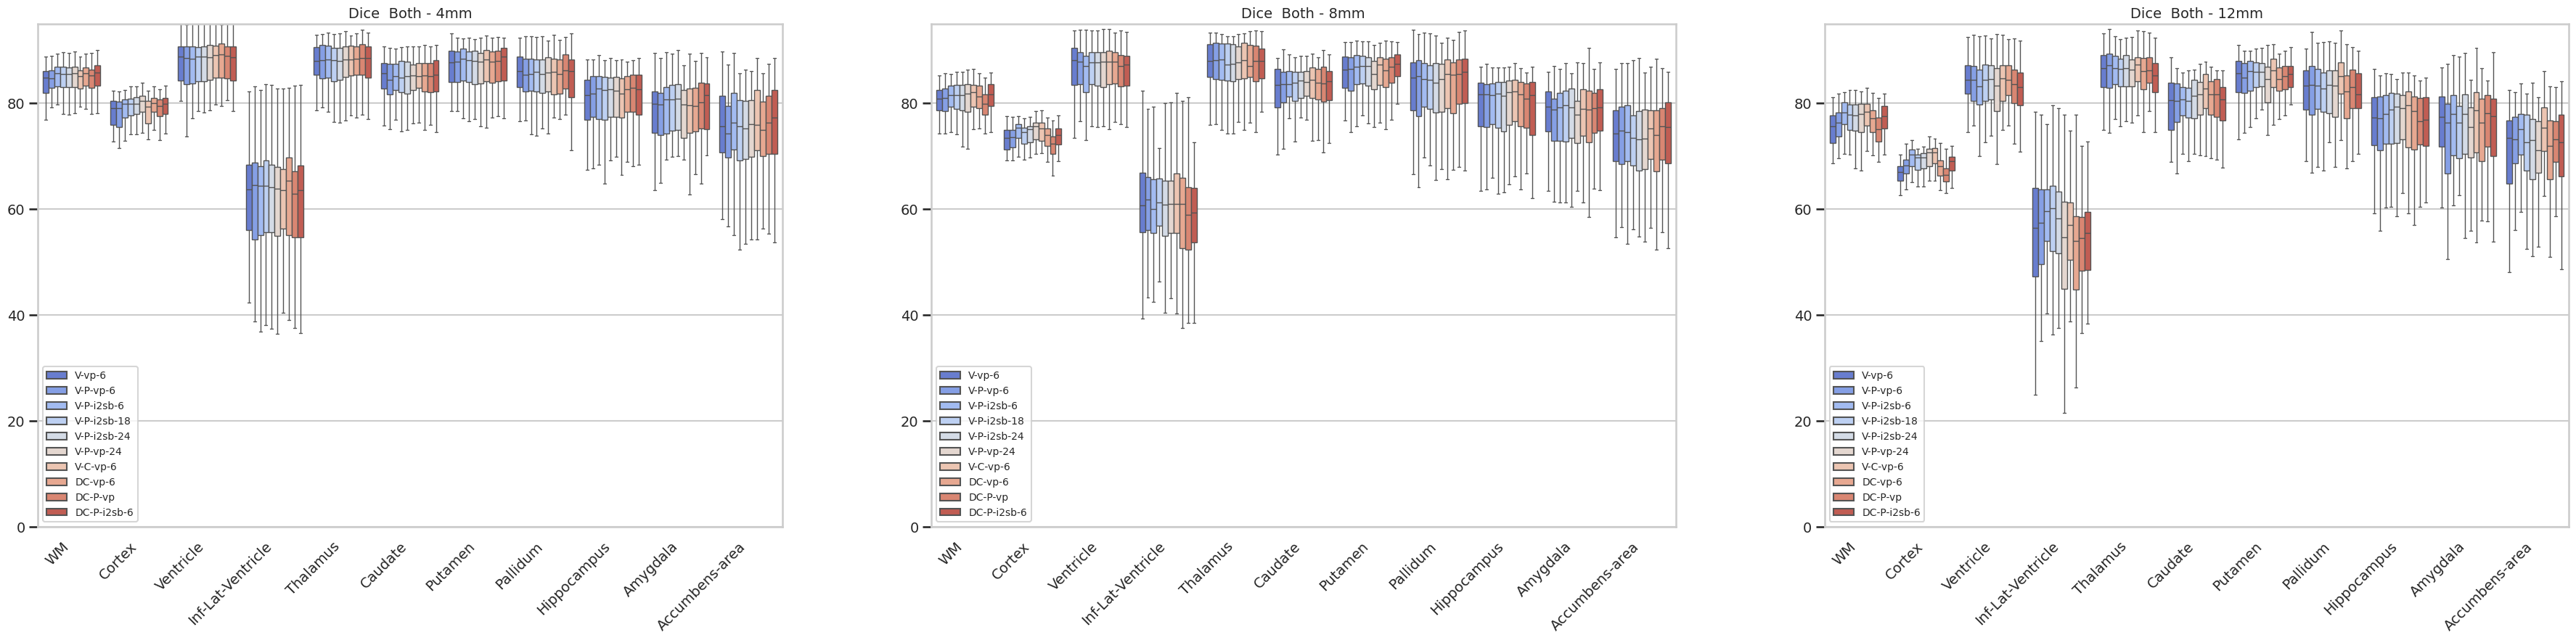

VE


<Figure size 640x480 with 0 Axes>

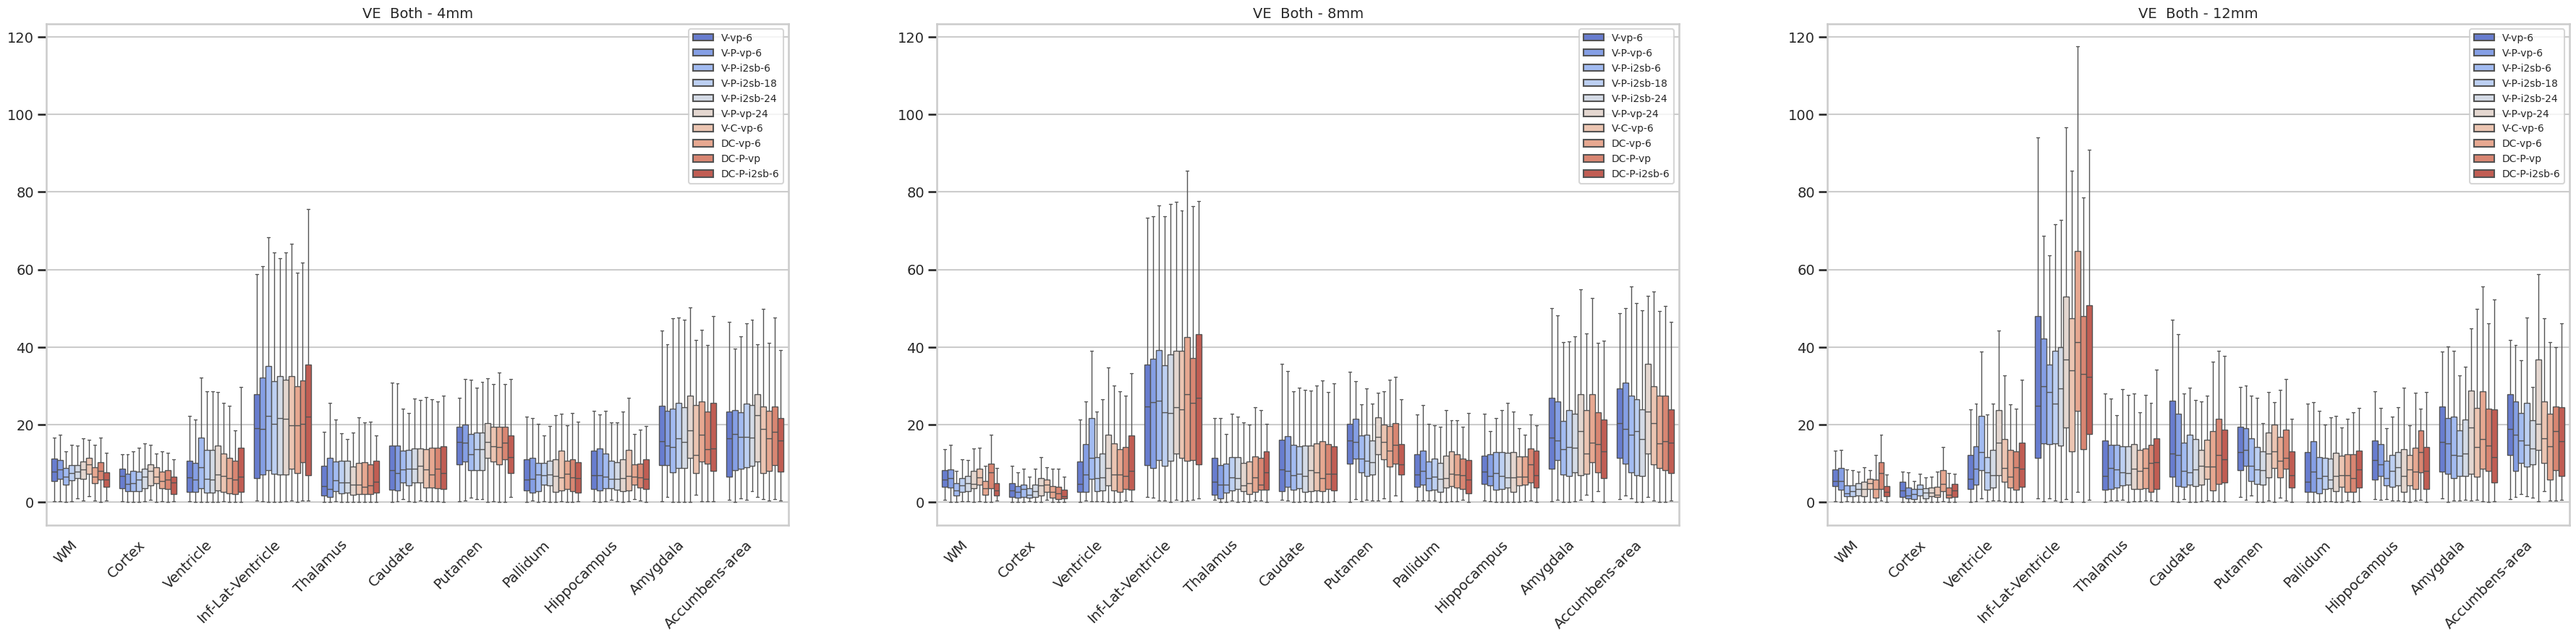

<Figure size 640x480 with 0 Axes>

In [221]:
### NO TOCAR 

# methods = ["photo_recon", 
#            "imputed_unet"]
methods = ["dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond"]
# methods = ["photo_recon", "imputed_unet","dbi-L1_gradient_perceptual-vanilla-vp-24_lr"]
# methods_labeled = {
#             "photo_recon": "Photo Recon",
#             "imputed_unet": "Imputation UNet",
#            "dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "Imputation DBI", 
#            }

# methods_cp = {"photo_recon_vs_imputed_unet": "Photo-UNet", 
#               "photo_recon_vs_dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "Photo-DBI",
#               "imputed_unet_vs_dbi-L1_gradient_perceptual-vanilla-vp-24_lr": "DBI-UNet"}




methods_labeled = {"dbi-L1_gradient-vanilla": "V-vp-6", 
                   "dbi-L1_gradient_perceptual-vanilla": "V-P-vp-6", 
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond": "V-P-i2sb-6", 
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18": "V-P-i2sb-18",
                   "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24": "V-P-i2sb-24",
                   "dbi-L1_gradient_perceptual-vanilla-vp-24": "V-P-vp-24", 
                   "dbi-L1_gradient_continuity-vanilla": "V-C-vp-6", 
                   "dbi-L1_gradient-dist_cond": "DC-vp-6", 
                   "dbi-L1_gradient_perceptual-dist_cond-vp": "DC-P-vp", 
                   "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond": "DC-P-i2sb-6"}

subfiles = ["4mm", "8mm", "12mm"]
records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))

# label_names = {2:"L-WM", 3:"L-Cortex", 4:"L-Ventricle", 5:"L-Inf-Lat-Ventricle", 10:"L-Thalamus",
#         11:"L-Caudate", 12:"L-Putamen", 13:"L-Pallidum", 17:"L-Hippocampus",
#         18:"L-Amygdala", 26:"L-Accumbens-area", 77:"L-WM hypo", 819:"L-HypoThal-noMB", 821:"L-Fornix",
#         843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc",
#         41:"R-WM", 42:"R-Cortex", 43:"R-Ventricle", 44:"R-Inf-Lat-Ventricle", 49:"R-Thalamus",
#         50:"R-Caudate", 51:"R-Putamen", 52:"R-Pallidum", 53:"R-Hippocampus",
#         54:"R-Amygdala", 58:"R-Accumbens-area", 77:"R-WM hypo", 820:"R-HypoThal-noMB", 822:"R-Fornix",
#         844:"R-MammillaryBody", 866:"R-BasalForebrain", 870:"R-SeptalNuc"
# }

label_names = {2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area",
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area"
}

for sub in subfiles:
        for file in files:
            for method in methods:
                file_results = f"{indir}/{file}/neurosynth/neurosynth_imputed_{method}_{sub}/segmentation.json"
                if os.path.exists(file_results):
                    df = pd.read_csv(file_results, sep="\t", header=None)
                    df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                    df = df[df["Label"] != 0]
                    
                    for i in label_names:
                        if i in df["Label"].values:
                            row = df[df["Label"] == i].copy()
                            records.append({
                                "Sub": sub,                # e.g., 4, 8, 12 (mm)
                                "Case": file,              # subject/case id
                                "Method": method,          # "unet" or "photo_recon"
                                "Label": int(row["Label"]),  # region id
                                "Dice": float(row["Dice"]),
                                "VE": float(row["VE"]),
                            })
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))
summary["Method_Label"] = summary["Method"].map(methods_labeled).fillna(summary["Method"].astype(str))
palette = sns.color_palette("coolwarm", n_colors=10)

# palette = ['#B974CC'] + ['#55A868'] 
# palette = [burgundy_light] + blue_palette

Sub = {"4mm": 4, 
    "8mm": 8, 
    "12mm": 12}


for metric in ["Dice", "VE"]:
    j = 0
    print(metric)
    fig, axes = plt.subplots(1,len(subfiles), figsize=(15*len(subfiles),9), sharey=True)
    for value in Sub:
        sub = value
        data_sub = summary[summary["Sub"] == sub].copy()

        ax = axes[j]
        sns.boxplot(data=data_sub, y=metric, x="Region", hue='Method_Label', palette=palette, dodge=True, showfliers=False, width=0.85, ax=ax)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.legend(title="", loc="best", fontsize=10)
        ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
        ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
        j += 1
    if metric =="Dice":
        plt.ylim(0,95)
    plt.show()
    plt.tight_layout()
    fig.savefig(f"./workdir/segmentations_neurosynth_alldbi_models_{metric}.svg")


# for metric in ["Dice", "VE"]:
#     out_path = f"./workdir/segmentations_neurosynth_real_unet_photo_{metric}.xlsx"
#     # #### normalize dice scores across subfile and method
#     with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
#         DD = pd.DataFrame(index=label_names.values(), columns=Sub)
#         EE = pd.DataFrame(index=label_names.values(), columns=Sub)
#         for value in subfiles:
#             ## COMPUTE THE P.VALUES
#             data_sub = summary[summary["Sub"] == value].copy()
#             for i in label_names.values():
#                 if i in data_sub["Region"].values:
#                     data_sub_label = data_sub[data_sub["Region"] == i].copy()
#                     g1 = data_sub_label[data_sub_label["Method"] == "photo_recon"][metric].values
#                     g2 = data_sub_label[data_sub_label["Method"] == "imputed_unet"][metric].values
#                     _,pval = mannwhitneyu(g1,g2)
#                     diff = (g2 - g1) # column to row comparison ****
#                     eff_size = diff.mean() / diff.std()

#                     DD[value][i] = pval
#                     EE[value][i] = eff_size
#         DD.to_excel(writer, sheet_name=f"Dice_pvals_{metric}")
#         EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}")


In [215]:
data_sub['Region']

18480                   WM
18481               Cortex
18482            Ventricle
18483    Inf-Lat-Ventricle
18484             Thalamus
               ...        
27484       MammillaryBody
27485       BasalForebrain
27486       BasalForebrain
27487            SeptalNuc
27488            SeptalNuc
Name: Region, Length: 9009, dtype: object

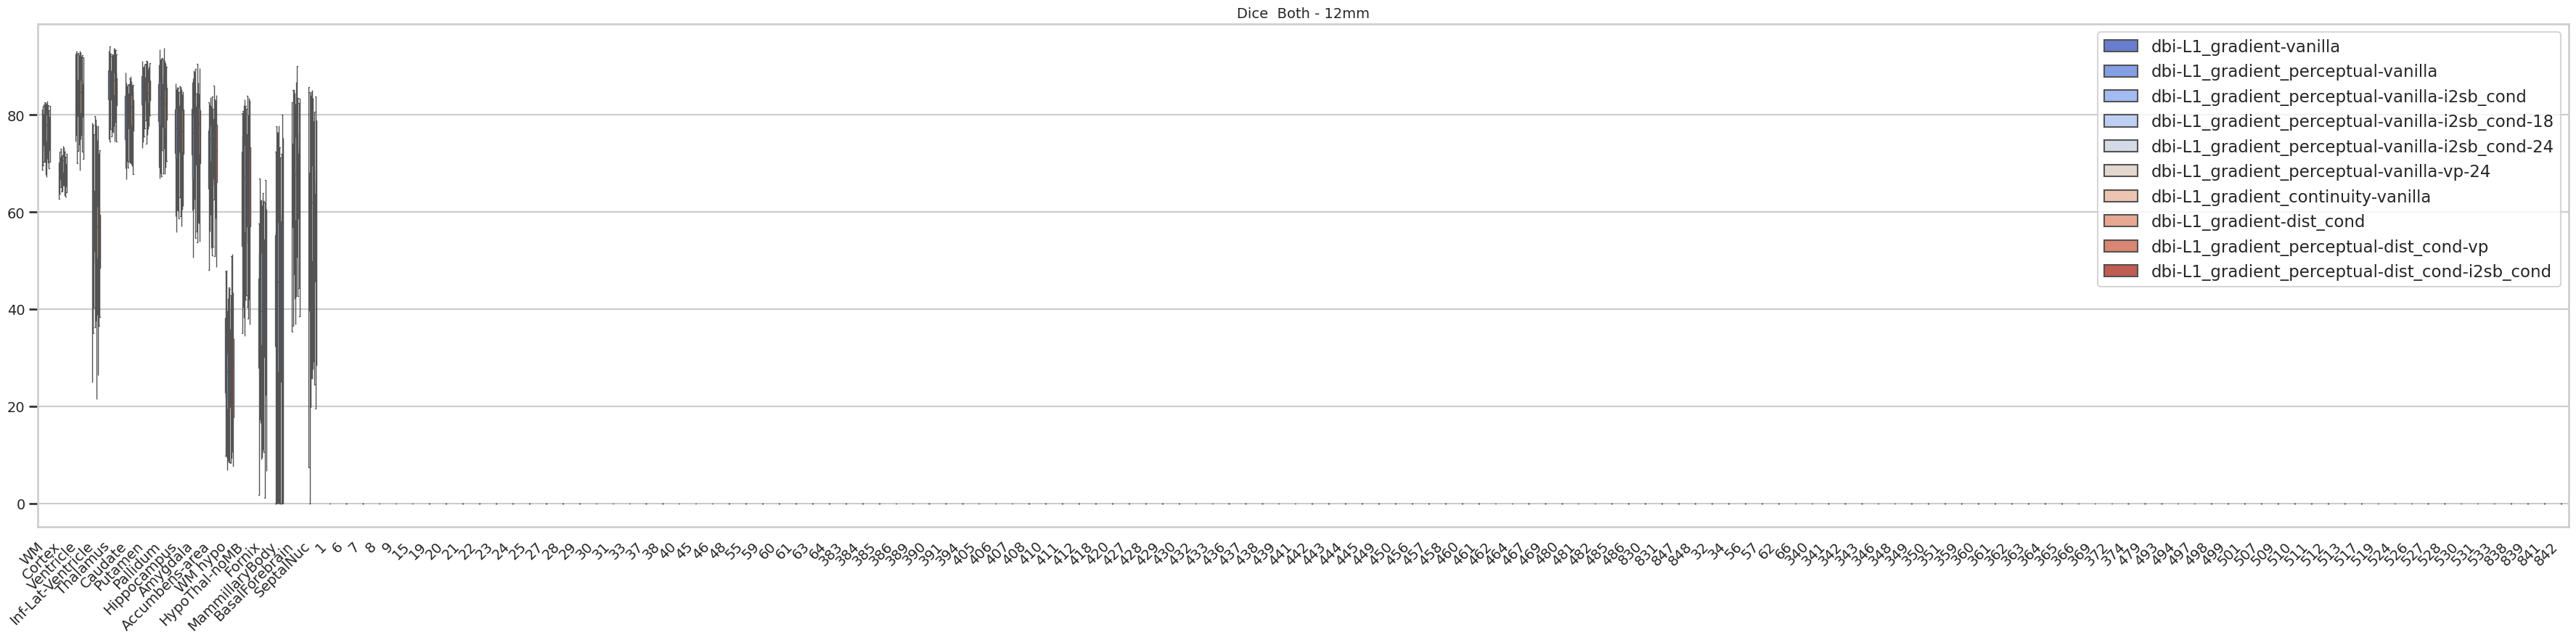

In [213]:
# for metric in ["Dice", "VE"]:
metric='Dice'
sub='12mm'
# j = 0
# print(metric)
fig, axes = plt.subplots(1,1, figsize=(15*len(subfiles),9), sharey=True)
# for value in Sub:
sub = value
data_sub = summary[summary["Sub"] == sub].copy()
ax=axes
sns.boxplot(data=data_sub, y=metric, x="Region", hue='Method', palette=palette, dodge=True, showfliers=False, width=0.5, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("")
ax.legend(title="", loc="best")
ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
ax.set_title(f"{metric}  Both - {sub}", fontsize=14)
j += 1

In [ ]:
methods = {"imputed_unet", 
           "photo_recon",
           }

subfiles = ["4mm","8mm","12mm"]
sides = {"left","right"}
side = "left"
records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))


# for side in sides:

if side == "left":
    label_names = {
        2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc"  # fill in as needed
    }
elif side =="right":
    label_names = {
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc"  # fill in as needed
    }

for sub in subfiles:
    for file in files:
        for method in methods:
            file_results = f"{indir}/{file}/synthseg_{method}_{sub}_{side}.json"
            if os.path.exists(file_results):
                df = pd.read_csv(file_results, sep="\t", header=None)
                df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                df = df[df["Label"] != 0]
                for _, r in df.iterrows():
                    records.append({
                        "Sub": sub,                # e.g., 4, 8, 12 (mm)
                        "Case": file,              # subject/case id
                        "Method": method,          # "unet" or "photo_recon"
                        "Label": int(r["Label"]),  # region id
                        "Dice": float(r["Dice"]),
                        "VE": float(r["VE"]),
                    })

burgundy_light = (176/255, 48/255, 96/255) # Photo_recon
blue_palette = sns.color_palette("Blues", n_colors=7) # lighter to darker blues

palette = [burgundy_light] + blue_palette
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))

out_path = f"./workdir/results/segmentations_neurosynth_real_unetvsphotorecon_{side}hemis.xlsx"

with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    D= []
    Sub = {"4mm": 4, 
        "8mm": 8, 
        "12mm": 12}

    DD = pd.DataFrame(index=label_names.values(), columns=Sub)
    EE = pd.DataFrame(index=label_names.values(), columns=Sub)
    

    for metric in ["Dice", "VE"]:
        print(metric)
        fig, axes = plt.subplots(1, len(Sub), figsize=(24, 6), sharey=True)
        for j, value in enumerate(Sub):
            sub = Sub[value]
            data_sub = summary[summary["Sub"] == sub].copy()

            # order labels on x-axis
            x_order = sorted(data_sub["Region"].unique(),
                            key=lambda x: (int(x) if str(x).isdigit() else 10**9, str(x)))
            ## COMPUTE THE P.VALUES
            
            for i in label_names:
                data_sub_label = data_sub[data_sub["Label"] == int(i)].copy()
                g1 = data_sub_label[data_sub_label["Method"] == "unet"][metric].values
                g2 = data_sub_label[data_sub_label["Method"] == "photo_recon"][metric].values
                _,pval = mannwhitneyu(g1,g2)
                diff = (g2 - g1) # column to row comparison ****
                eff_size = diff.mean() / diff.std()

                DD[value][label_names[i]] = pval
                EE[value][label_names[i]] = eff_size


            ax = axes[j]
            sns.boxplot(data=data_sub, x="Region", y=metric,
                        hue="Method", palette=palette, dodge=True, showfliers=False, width=0.5, ax=ax)
            
            ax.set_ylabel("")
            ax.set_xlabel("")
            ax.legend(title="", loc="best")
            ax.tick_params(axis='y', which='both', left=True, labelleft=True)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_title(f"{metric} {side} hemis - {sub} mm")


        plt.show()
        plt.tight_layout()
        # pvals = pd.DataFrame.from_records(D)
        fig.savefig(f"./workdir/results/segmentations_neurosynth_real_unetvsphotorecon_{side}hemis_{metric}.svg")

        DD.to_excel(writer, sheet_name=f"Dice_pvals_{metric}")
        EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}")


In [ ]:
methods = {"unet", 
           "photo_recon",
           }

subfiles = [4,8,12]
sides = {"left","right"}
side = "left"
records = []
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
files = os.listdir(Path(indir))


# for side in sides:

if side == "left":
    label_names = {
        2:"WM", 3:"Cortex", 4:"Ventricle", 5:"Inf-Lat-Ventricle", 10:"Thalamus",
        11:"Caudate", 12:"Putamen", 13:"Pallidum", 17:"Hippocampus",
        18:"Amygdala", 26:"Accumbens-area", 77:"WM hypo", 819:"HypoThal-noMB", 821:"Fornix",
        843:"MammillaryBody", 865:"BasalForebrain", 869:"SeptalNuc"  # fill in as needed
    }
elif side =="right":
    label_names = {
        41:"WM", 42:"Cortex", 43:"Ventricle", 44:"Inf-Lat-Ventricle", 49:"Thalamus",
        50:"Caudate", 51:"Putamen", 52:"Pallidum", 53:"Hippocampus",
        54:"Amygdala", 58:"Accumbens-area", 77:"WM hypo", 820:"HypoThal-noMB", 822:"Fornix",
        844:"MammillaryBody", 866:"BasalForebrain", 870:"SeptalNuc"  # fill in as needed
    }

for sub in subfiles:
    for file in files:
        for method in methods:
            file_results = f"{indir}/{file}/neurosynth_{method}_{sub}_{side}/results.json"
            if os.path.exists(file_results):
                df = pd.read_csv(file_results, sep="\t", header=None)
                df.columns = ["Label", "VE", "Dice", "Jaccard"]  # rename columns as needed
                df = df[df["Label"] != 0]
                for _, r in df.iterrows():
                    records.append({
                        "Sub": sub,                # e.g., 4, 8, 12 (mm)
                        "Case": file,              # subject/case id
                        "Method": method,          # "unet" or "photo_recon"
                        "Label": int(r["Label"]),  # region id
                        "Dice": float(r["Dice"]),
                        "VE": float(r["VE"]),
                    })

burgundy_light = (176/255, 48/255, 96/255) # Photo_recon
blue_palette = sns.color_palette("Blues", n_colors=7) # lighter to darker blues

palette = [burgundy_light] + blue_palette
summary = pd.DataFrame.from_records(records)
summary["Region"] = summary["Label"].map(label_names).fillna(summary["Label"].astype(str))

out_path = f"./workdir/results/segmentations_neurosynth_real_unetvsphotorecon_{side}hemis.xlsx"

with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    D= []
    Sub = {"4mm": 4, 
        "8mm": 8, 
        "12mm": 12}

    DD = pd.DataFrame(index=label_names.values(), columns=Sub)
    EE = pd.DataFrame(index=label_names.values(), columns=Sub)
    

    for metric in ["Dice", "VE"]:
        print(metric)
        fig, axes = plt.subplots(1, len(Sub), figsize=(24, 6), sharey=True)
        for j, value in enumerate(Sub):
            sub = Sub[value]
            data_sub = summary[summary["Sub"] == sub].copy()

            # order labels on x-axis
            x_order = sorted(data_sub["Region"].unique(),
                            key=lambda x: (int(x) if str(x).isdigit() else 10**9, str(x)))
            ## COMPUTE THE P.VALUES
            
            for i in label_names:
                data_sub_label = data_sub[data_sub["Label"] == int(i)].copy()
                g1 = data_sub_label[data_sub_label["Method"] == "unet"][metric].values
                g2 = data_sub_label[data_sub_label["Method"] == "photo_recon"][metric].values
                _,pval = mannwhitneyu(g1,g2)
                diff = (g2 - g1) # column to row comparison ****
                eff_size = diff.mean() / diff.std()

                DD[value][label_names[i]] = pval
                EE[value][label_names[i]] = eff_size


            ax = axes[j]
            sns.boxplot(data=data_sub, x="Region", y=metric,
                        hue="Method", palette=palette, dodge=True, showfliers=False, width=0.5, ax=ax)
            
            ax.set_ylabel("")
            ax.set_xlabel("")
            ax.legend(title="", loc="best")
            ax.tick_params(axis='y', which='both', left=True, labelleft=True)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_title(f"{metric} {side} hemis - {sub} mm")


        plt.show()
        plt.tight_layout()
        # pvals = pd.DataFrame.from_records(D)
        fig.savefig(f"./workdir/results/segmentations_neurosynth_real_unetvsphotorecon_{side}hemis_{metric}.svg")

        DD.to_excel(writer, sheet_name=f"Dice_pvals_{metric}")
        EE.to_excel(writer, sheet_name=f"Dice_deffect_{metric}")


In [ ]:
metric = "Dice"  # or "VE"
methods = ("unet", "photo_recon")

# One-column result table indexed by your label order
D = pd.DataFrame(index=label_order, columns=["p_wilcoxon", "N_pairs", "mean_unet", "mean_photo_recon", "mean_diff"], dtype=float)

base = data_sub.copy()  # your full filtered DF (do NOT overwrite inside loop)

for i in label_order:
    # 1) keep only this label
    block = base[base["Label"] == i]

    # 2) pivot to align pairs across methods (paired by Sub+Case; add Region if needed)
    wide = block.pivot_table(
        index=["Sub", "Case"],   # or ["Sub","Case","Region"] if that’s the correct pairing unit
        columns="Method",
        values=metric,
        aggfunc="mean"
    )

    # 3) ensure both methods exist and build paired data
    if set(methods).issubset(wide.columns):
        pair = wide.loc[:, list(methods)].dropna()
        a = pair[methods[0]].to_numpy()
        b = pair[methods[1]].to_numpy()

        if len(pair) >= 1:
            try:
                stat, p = mannwhitneyu(a, b)  # two-sided by default
            except ValueError:
                p = np.nan
        else:
            p = np.nan

        # 4) store results
        D.loc[i, "p_wilcoxon"] = p
        D.loc[i, "N_pairs"] = len(pair)
        D.loc[i, "mean_unet"] = a.mean() if len(a) else np.nan
        D.loc[i, "mean_photo_recon"] = b.mean() if len(b) else np.nan
        D.loc[i, "mean_diff"] = (a - b).mean() if len(pair) else np.nan
    else:
        D.loc[i, :] = np.nan  # one or both methods missing for this label

In [ ]:
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/volume_metrics.txt"
files = os.listdir(Path(indir))
methods = {
    "photo_recon",
    "unet",
}
 
subfiles = {
    "_4_",
    "_8_",
    "_12_"}
sides = {
    "left"}

with open(output_txt, "w") as f:
    
    for file in files:
        for method in methods:
            for side in sides:
                for sub in subfiles:
                    cmd = (
                        f"mri_compute_overlap "
                        f"-a "
                        f"-l {indir}/{file}/neurosynth_{method}{sub}{side}/results.json "
                        f"{indir}/{file}/neurosynth_{method}{sub}{side}/segmentation_resampled.mgz "
                        f"{indir}/{file}/neurosynth_mri_{side}/segmentation.mgz "
                    )
                    f.write(cmd + "\n")

In [ ]:
indir = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/volume_metrics.txt"
files = os.listdir(Path(indir))
methods = {"unet_10", 
           "dbi_heun_vanilla_vp_10st",
           "dbi_heun_vanilla_continuity_vp_10st",
           "dbi_heun_vanilla_perceptual_i2sb_10st",
           "dbi_heun_vanilla_perceptual_vp_10st",
           "dbi_heun_dist_cond_perceptual_vp_10st",
           "dbi_heun_dist_cond_vp_10st", 
           "dbi_heun_dist_cond_perceptual_i2sb_10st"
           }

with open(output_txt, "w") as f:
    for file in files:
        indir = Path(f"/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic/{file}/")
        for method in methods:
            cmd = (
                f"mri_compute_overlap "
                f"-a "
                f"-l {indir}/dist_10-best/segmentation_imputed_{method}/results.json "
                f"{indir}/dist_10-best/segmentation_imputed_{method}/segmentation_resampled.mgz "
                f"{indir}/synthetic_gt_segmentation/segmentation.mgz "
            )
            f.write(cmd + "\n")

/home/scratch/ipykernel_1991497/3957313271.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=labels, vert=True, showfliers=False)
/home/scratch/ipykernel_1991497/3957313271.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=labels, vert=True, showfliers=False)
/home/scratch/ipykernel_1991497/3957313271.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=labels, vert=True, showfliers=False)
/home/scratch/ipykernel_1991497/3957313271.

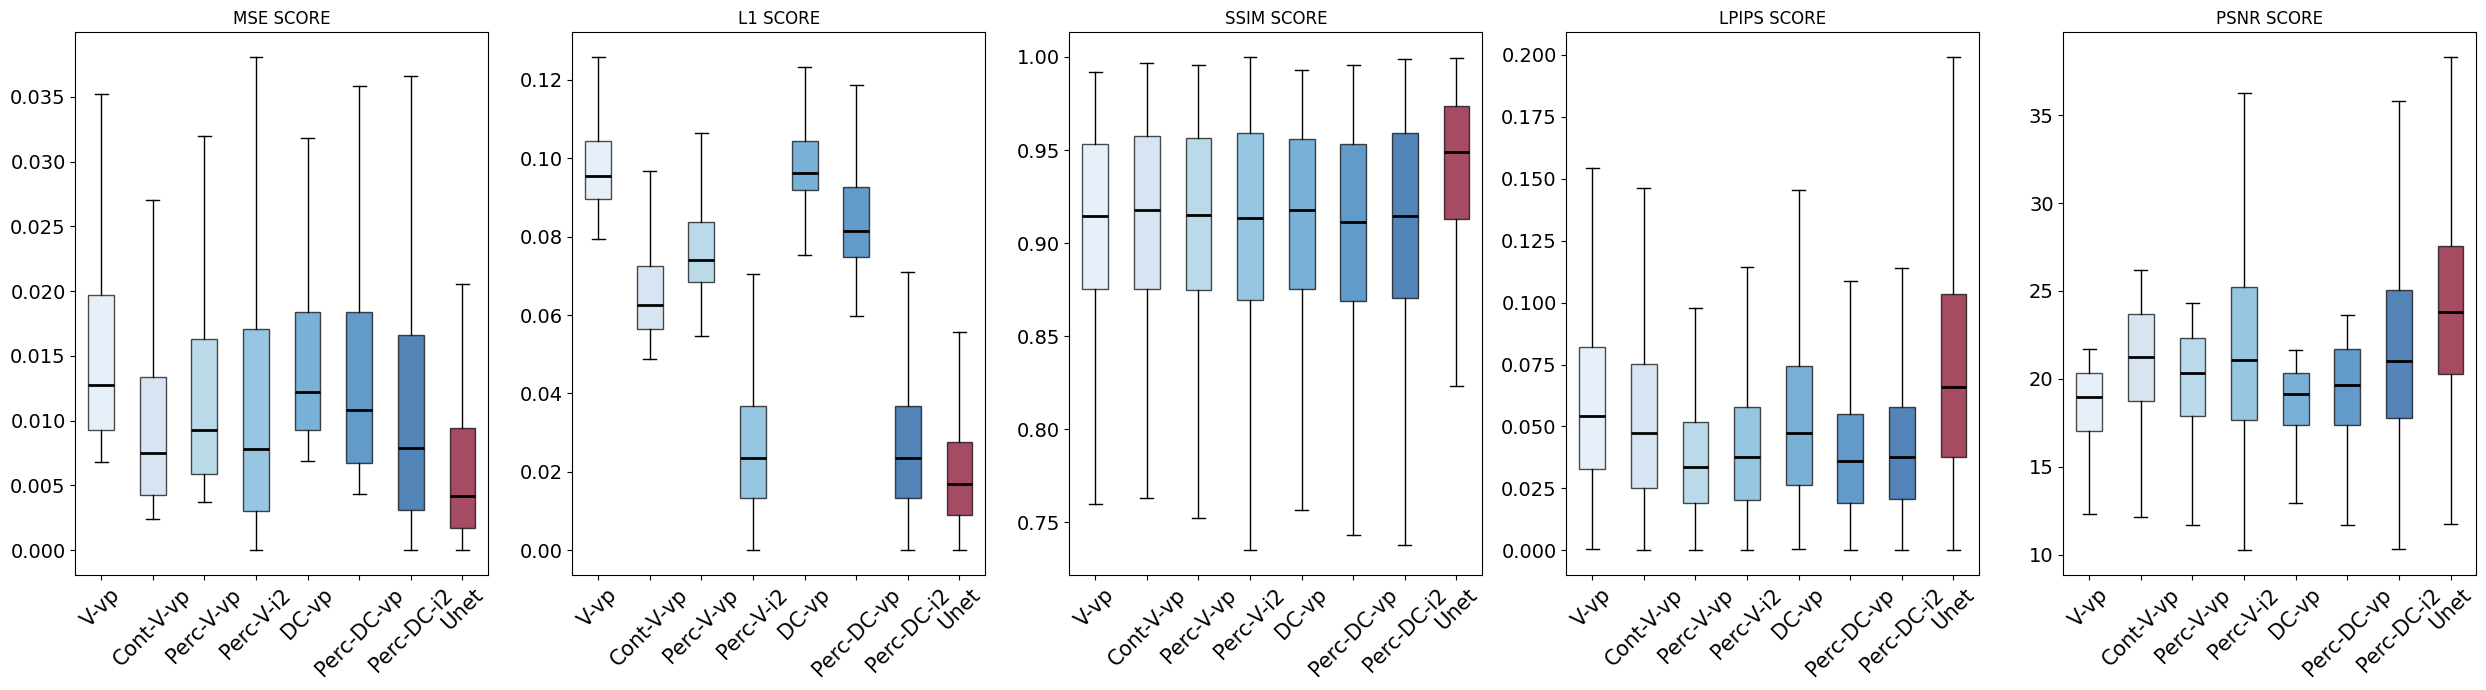

In [2]:
# --------------------
# Config
# --------------------
methods = [
     "dbi-L1_gradient-vanilla",
    "dbi-L1_gradient_continuity-vanilla",
    "dbi-L1_gradient_perceptual-vanilla",
    "dbi-L1_gradient_perceptual-vanilla-i2sb_cond",
    "dbi-L1_gradient-dist_cond",
    "dbi-L1_gradient_perceptual-dist_cond-vp",
    "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond",
    "unet"
]

method_labels = {
    "dbi-L1_gradient-vanilla": "V-vp",
    "dbi-L1_gradient_continuity-vanilla": "Cont-V-vp",
    "dbi-L1_gradient_perceptual-vanilla": "Perc-V-vp",
     "dbi-L1_gradient_perceptual-vanilla-i2sb_cond": "Perc-V-i2",
    "dbi-L1_gradient-dist_cond": "DC-vp",
    "dbi-L1_gradient_perceptual-dist_cond-vp": "Perc-DC-vp",
     "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond": "Perc-DC-i2",
    "unet": "Unet"
}
root_path = '/homes/1/ma1282/marina_almeria/dbi/workdir/'

# --------------------
# Helper to read CSV correctly
# --------------------
def load_csv(path):
    df = pd.read_csv(path, header=None)
    df = df[0].str.split(",", expand=True)
    df.columns = ["abs_dist", "ssim_score", "mse_score", "l1_score", "lpips_score", "psnr_score"]
    df = df.astype(float)
    return df

colors = plt.cm.tab10.colors
# --------------------
# Plot
# --------------------
blue_palette = sns.color_palette("Blues", n_colors=7) # lighter to darker blues
burgundy = (128/255, 0, 32/255)  # RGB for burgundy
palette = blue_palette + [burgundy]
metrics = ["mse_score", "l1_score", "ssim_score",  "lpips_score", "psnr_score"]
labels = []
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 7), sharex=False)

for i, metric in enumerate(metrics):
    data_to_plot = []
    labels = []
    box_colors = []
    for j,method in enumerate(methods):
        if "unet" not in method:
            base_path = f"{root_path}{method}"
            csv_file = os.path.join(base_path, "best_ckpt", "metrics_validation_normalized_stack.csv")
        else:
            csv_file = "/homes/1/ma1282/marina_almeria/unet_eugenio/workdir/validation_2dsamples/metrics_validation_stack_.csv"
        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file, sep=",")
            
            # if metric == "psnr_score":
            #     data_to_plot.append(np.log(df[metric].values))
            #     metric.replace("psnr", "log_psnr")
            # else:
            data_to_plot.append(df[metric].values)
            labels.append(method_labels[method])
            box_colors.append(palette[j % len(palette)])
    
    bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=labels, vert=True, showfliers=False)
    # Set colors from seaborn palette
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Style median lines thicker
    for median in bp['medians']:
        median.set_color("black")
        median.set_linewidth(2)
    axes[i].set_title(metric.replace("_", " ").upper())
    # if i == (len(metrics) -1):
        # axes[i].set_title(metric.replace("psnr_score", "log psnr score").upper())
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=15)
plt.tight_layout()
plt.show()
# fig.savefig("/homes/1/ma1282/marina_almeria/dbi/workdir/2d_validation_boxplots.svg")

In [ ]:
##### STATISTICAL ANALYSIS - EFFECT SIZE
excel_out = "./workdir/pairwise_effect_sizes_2dvoxelmetrics.xlsx"

with pd.ExcelWriter(excel_out, engine="xlsxwriter") as writer:
    all_df_methods = {}
    for i, metric in enumerate(metrics):

        for j,method in enumerate(methods):
            if "unet" not in method:
                base_path = f"{root_path}{method}"
                csv_file = os.path.join(base_path, "best_ckpt", "metrics_validation_normalized_stack.csv")
            else:
                csv_file = "/homes/1/ma1282/marina_almeria/unet_eugenio/workdir/validation_2dsamples/metrics_validation_stack_.csv"
            if os.path.exists(csv_file):
                rf = pd.read_csv(csv_file, sep=",")
                all_df_methods[method] = rf[metric].values

        P = pd.DataFrame(index=methods, columns=methods, dtype=float)
        for i, mi in enumerate(all_df_methods):
            for j, mj in enumerate(all_df_methods):
                if i > j:
                    g1 = all_df_methods[mi] 
                    g2 = all_df_methods[mj]

                    diff = (g2 - g1) # column to row comparison ****
                    eff_size = diff.mean() / diff.std()
                    P.loc[mi,mj] = eff_size
        P.to_excel(writer, sheet_name=metric)

excel_out = "./workdir/pairwise_wilcoxon_2dvoxelmetrics.xlsx"

with pd.ExcelWriter(excel_out, engine="xlsxwriter") as writer:
    all_df_methods = {}
    for i, metric in enumerate(metrics):

        for j,method in enumerate(methods):
            if "unet" not in method:
                base_path = f"{root_path}{method}"
                csv_file = os.path.join(base_path, "best_ckpt", "metrics_validation_normalized_stack.csv")
            else:
                csv_file = "/homes/1/ma1282/marina_almeria/unet_eugenio/workdir/validation_2dsamples/metrics_validation_stack_.csv"
            if os.path.exists(csv_file):
                rf = pd.read_csv(csv_file, sep=",")
                all_df_methods[method] = rf[metric].values

        P = pd.DataFrame(index=methods, columns=methods, dtype=float)
        for i, mi in enumerate(all_df_methods):
            for j, mj in enumerate(all_df_methods):
                if i > j:
                    g1 = all_df_methods[mi] 
                    g2 = all_df_methods[mj]
                    _,P.loc[mi,mj] = mannwhitneyu(g1, g2)
        P.to_excel(writer, sheet_name=metric)


In [ ]:
indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
methods = {"dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond"}
dist="12mm"
files = os.listdir(Path(indir))
segmentations =[]
for file in files:
    for m in methods:
        fname = f"{indir}/{file}/synthetic_imputed_{m}_{dist}.nii.gz"
        if os.path.exists(fname):
            os.rename(fname, f"{indir}/{file}/synthseg_{m}_{dist}.mgz")
        elif os.path.exists(f"{indir}/{file}/synthseg_{m}_{dist}.mgz")==False:
            segmentations.append(f"{file}/synthseg_{m}_{dist}.mgz")


In [ ]:
#### COMMANDS TO GENERATE BINARY MASKS

indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/synthseg_mask.txt"
files = os.listdir(Path(indir))
# methods = {"dbi-L1_gradient-vanilla", "dbi-L1_gradient_perceptual-vanilla", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-18", "dbi-L1_gradient_perceptual-vanilla-i2sb_cond-24", "dbi-L1_gradient_perceptual-vanilla-vp-24", "dbi-L1_gradient_continuity-vanilla", "dbi-L1_gradient-dist_cond", "dbi-L1_gradient_perceptual-dist_cond-vp", "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond"}
dists=["4mm", "8mm", "12mm"]
with open(output_txt, "w") as f:
    for dist in dists:
        for file in files:
            # cmd = (
            #     f"mri_synthseg "
            #     f"--i {indir}/{file}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.nii.gz "
            #     f"--o {indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.mgz "
            #     "--threads 20 "
            # )
            # f.write(cmd + "\n")

            cmd = (
                f"mri_convert "
                f"{indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.mgz "
                f"{indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.mgz "
                f"-rl {indir}/{file}/synthseg_mri.mgz "
                f"-rt nearest " 
                f"-odt float "
            )
            f.write(cmd + "\n")

    for dist in dists:
        for file in files:
            cmd = (
                f"mri_compute_overlap "
                f"-a "
                f"-l {indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.json "
                f"{indir}/{file}/synthseg_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.mgz "
                f"{indir}/{file}/synthseg_mri.mgz "
            )
            f.write(cmd + "\n")

#                 cmd = (
#                     f"mri_compute_overlap "
#                     f"-a "
#                     f"-l {indir}/{file}/synthseg_{method}_{dist}.json "
#                     f"{indir}/{file}/synthseg_{method}_{dist}.mgz "
#                     f"{indir}/{file}/synthseg_mri.mgz "
#                 )
#                 f.write(cmd + "\n")
# print(f"Commands written to {output_txt}")

In [ ]:
#### COMMANDS TO GENERATE BINARY MASKS

indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/binarize.txt"
files = os.listdir(Path(indir))

# with open(output_txt, "w") as f:
    # for dist in [4, 8, 12, 16]:
    # dist = 4
    # outdir = "./workdir/"
    # file = files[0]
    # for file in files:
file="19-019"
indir = Path(f"/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina/{file}")
# outdir = f"{indir.parent}/photo_recon_{dist}mm"
seg = f"{indir}/synthseg_photo_recon_4mm.mgz"
im = f"{indir.parent}/mri.deformed.photo_space.mgz"
mask_path_right = f"{indir.parent}/mri_right_mask.nii.gz"
mask_path_left = f"{indir.parent}/mri_left_mask.nii.gz"
cerebrum_key_left = [2, 3, 4, 5, 8,10, 11, 12, 13, 17, 18, 26, 28]

d = nib.load(seg)
i, affine_photo_recon = MRIread(im)
s, affine = MRIread(seg)

s_ = s.copy()
m = np.isin(s_, cerebrum_key_left)

s_[~m] = 0 # select only positive values
m2 = np.isin(s_, cerebrum_key_left)
m_left = s_.copy()
m_right = s_.copy()

m_left[~m2] = 0
m_left[m_left > 0] = 1

# ### DISCARD THE CONNECTED COMPONENTS THAT DO NOT BELONG TO THE LARGEST COMPONENT!!!
l_left, f_left = ndimage.label(m_left)
sizes = ndimage.sum(m_left, l_left, range(1, f_left + 1))
largest = 1 + np.argmax(sizes)
m_left = m_left * (l_left == largest)
m_left =  ndimage.binary_fill_holes(m_left)


m_right = 1 - m_left
m_right[s == 0] = 0
l_right, f_right = ndimage.label(m_right)
sizes = ndimage.sum(m_right, l_right, range(1, f_right + 1))
largest = 1 + np.argmax(sizes)
m_right = m_right * (l_right == largest)
m_right = ndimage.binary_fill_holes(m_right)

morph_kernel = torch.ones(5,5)
m_left_th, m_right_th = torch.tensor(m_left), torch.tensor(m_right)
m_left_th = morph.closing(m_left_th.long().unsqueeze(0), morph_kernel)
m_right_th = morph.closing(m_right_th.long().unsqueeze(0), morph_kernel)
    # nib.save(nib.Nifti1Image(m_left_th.squeeze().numpy(), affine, d.header), mask_path_left)
    # nib.save(nib.Nifti1Image(m_right_th.squeeze().numpy(), affine, d.header), mask_path_right)

        # cmd = (
        #     f"mri_mask "
        #     f"{im} "
        #     f"{mask_path_right} "
        #     f"{indir.parent}/mri_right.deformed.mgz "
        # )
        # f.write(cmd + "\n")

        # cmd = (
        #     f"mri_mask "
        #     f"{im} "
        #     f"{mask_path_left} "
        #     f"{indir.parent}/mri_left.deformed.mgz "
        # )
        # f.write(cmd + "\n")



In [56]:
##### GENERATE COMMAND.TXT FILE TO RUN SEGMENTATIONS IN PARALLEL 
directory = "/homes/1/ma1282/marina_almeria/dbi/workdir/recon_synthetic"
output_txt = "/homes/1/ma1282/marina_almeria/dbi/scripts/neurosynth_extra.txt"

with open(output_txt, "w") as f:
    for i in os.listdir(directory):
        root_folder = f"{directory}/{i}/dist_10-best"
        
        # if not os.path.isdir(root_folder):
        #     continue
        
        # # for file in os.listdir(root_folder):
        #     if "segmentation" not in file:
        #         input_path = os.path.join(root_folder, file)
        #         newfile = file[:file.find(".mgz")]

        #         output_path = os.path.join(root_folder, f"segmentation_{newfile}")
        #         # print(output_path)
        cmd = (
            f"/autofs/vast/lemon/software/NeuroSynth/run_NeuroSynth.sh "
            f"--i {root_folder}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_resampled.mgz "
            f"--o {root_folder}/segmentation_imputed_dbi-L1_gradient_perceptual-vanilla-vp-24 "
            f"--mode left-hemi "
            f"--device cuda "
            f"--threads -1"
        )
        f.write(cmd + "\n")

print(f"Commands written to {output_txt}")

Commands written to /homes/1/ma1282/marina_almeria/dbi/scripts/neurosynth_extra.txt


In [ ]:
##### GENERATE PHOTO RECONS W DIFFERENT RESOLUTIONS #####

photo_recon, affine = MRIread("/autofs/cluster/vive/UW_photo_recon/UW_photo_recon_clean202412/photo_recon_MriOnly/17-0333/photo_recon.mgz")

for resize in [2, 3, 4]:
    new_photo = []
    new_shape = photo_recon.shape[2] // resize
    for j in range(new_shape):
        real_idx = j*resize
        new_photo.append(photo_recon[:,:,real_idx])
    new_photo = np.stack(new_photo, axis=2)
    new_affine = affine.copy()
    new_affine[:,2]*=resize
    MRIwrite(new_photo, new_affine, f"/autofs/cluster/vive/UW_photo_recon/UW_photo_recon_clean202412/photo_recon_MriOnly/17-0333/photo_recon_{resize*4}_mm.mgz")

In [ ]:
#### STATISTICAL ANALYSIS ##### pair-wise comparison
methods = [
     "dbi-L1_gradient-vanilla",
    "dbi-L1_gradient_continuity-vanilla",
    "dbi-L1_gradient_perceptual-vanilla",
    "dbi-L1_gradient_perceptual-vanilla-i2sb_cond",
    "dbi-L1_gradient-dist_cond",
    "dbi-L1_gradient_perceptual-dist_cond-vp",
    "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond",
    
    "unet_eugenio"
]

method_labels = {
    "dbi-L1_gradient-vanilla": "V-vp",
    "dbi-L1_gradient_continuity-vanilla": "Cont-V-vp",
    "dbi-L1_gradient_perceptual-vanilla": "Perc-V-vp",
     "dbi-L1_gradient_perceptual-vanilla-i2sb_cond": "Perc-V-i2",
    "dbi-L1_gradient-dist_cond": "DC-vp",
    "dbi-L1_gradient_perceptual-dist_cond-vp": "Perc-DC-vp",
     "dbi-L1_gradient_perceptual-dist_cond-i2sb_cond": "Perc-DC-i2",
    "unet_eugenio": "Unet"
}

# --------------------
# Helper: load metric series for a method
# --------------------
def load_metric_series(method: str, metric: str) -> pd.Series | None:
    path = get_csv_path(method)
    if not os.path.exists(path):
        print(f"[WARN] Missing file for {method}: {path}")
        return None
    df = pd.read_csv(path, sep=",")
    if metric not in df.columns:
        print(f"[WARN] Missing column '{metric}' in {path}")
        return None
    return df[metric].dropna()

metrics = ["mse_score", "l1_score", "ssim_score",  "lpips_score", "psnr_score"]
# --------------------
# Build pairwise p-value matrices and write to Excel
# --------------------
out_xlsx = "pairwise_wilcoxon_pvalues.xlsx"
with pd.ExcelWriter(out_xlsx) as writer:  # default engine
    for metric in metrics:
        series_by_label = {}
        for m in methods:
            s = load_metric_series(m, metric)
            if s is None or len(s) == 0:
                continue
            series_by_label[method_labels[m]] = s.reset_index(drop=True)

        labels = list(series_by_label.keys())
        if len(labels) < 2:
            continue

        min_len = min(len(s) for s in series_by_label.values())
        for k in labels:
            series_by_label[k] = series_by_label[k].iloc[:min_len].to_numpy()

        P = pd.DataFrame(np.nan, index=labels, columns=labels)
        for i, a in enumerate(labels):
            for j, b in enumerate(labels):
                if j <= i:
                    continue
                try:
                    _, p = ttest_rel(series_by_label[a], series_by_label[b], nan_policy="omit")
                except ValueError:
                    p = np.nan
                P.loc[a, b] = p

        P = P.combine_first(P.T)
        np.fill_diagonal(P.values, 1.0)
        P = P.loc[sorted(P.index), sorted(P.columns)]

        P.to_excel(writer, sheet_name=metric, float_format="%.3e")

print(f"✅ Wrote Excel file: {out_xlsx}")


In [ ]:
# for the prediction of the half brains to restich

indir = "/cluster/vive/UW_photo_recon/FLAIR_Scan_Data/Rotated_QC/UWA_fixed_tissue_dataset_bids/derivatives/12_photo_recons_4_marina"
for file in os.listdir(indir):
    for dist in ["4mm", "8mm", "12mm"]:
        vol_left,aff = MRIread(f"{indir}/{file}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_left.nii.gz")
        vol_right,_ = MRIread(f"{indir}/{file}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_right.nii.gz")

        vol_left = vol_left.astype(float)
        vol_right = vol_right.astype(float)

        # max_joint = np.zeros(3)
        # norm_sum_vols = np.zeros_like(vol_left)
        # for c in range(vol_left.shape[-1]):
        #     ax_r = vol_left[vol_left[...,c]>5]
        #     ax_l = vol_right[vol_right[...,c]>5]
        #     max_1 = np.median(ax_l)
        #     max_2 = np.median(ax_r)
        #     max_joint = (max_1 + max_2)/2
        #     norm_sum_vols[...,c] = vol_left[...,c]/max_1 + vol_right[...,c]/max_2
        #     norm_sum_vols[...,c]*=max_joint


        combined_dummy = vol_left + vol_right
        combined_dummy = combined_dummy.astype(np.uint8)

        mask_l = np.zeros(vol_left.shape[:-1]) 
        mask_l[vol_left.mean(-1)>10] = 1
        mask_r = np.zeros(vol_right.shape[:-1]) 
        mask_r[vol_right.mean(-1)>10] = 1

        norm_mask = (mask_l + mask_r)
        norm_mask[norm_mask>1] = 0.5

        combined_dummy = combined_dummy * norm_mask[...,None]
        MRIwrite(combined_dummy, aff, f"{indir}/{file}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.nii.gz")
        print(f"Saved: {indir}/{file}/imputed_dbi-L1_gradient_perceptual-vanilla-vp-24_{dist}_lr.nii.gz")

# combined = combined.astype(np.uint8)
# plt.figure(figsize=(30,10))
# plt.subplot(1,4,1)
# plt.imshow(np.rot90(vol_left[:,100].astype(np.uint8)), cmap='gray')
# plt.subplot(1,4,2)
# plt.imshow(np.rot90(vol_right[:,100].astype(np.uint8)), cmap='gray')
# plt.subplot(1,4,3)
# plt.imshow(np.rot90(combined_dummy[:,100].astype(np.uint8)), cmap='gray')
# plt.subplot(1,4,4)
# plt.imshow(np.rot90(norm_sum_vols[:,100].astype(np.uint8)), cmap='gray')